# Scikit-Learn Example in PyMC: Gaussian Process Classifier

In this notebook we want to describe how to port a couple of classification  examples from [scikit-learn's documentation (classifier comparison)](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py) to PyMC. We focus in the classical [`moons`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html#sklearn.datasets.make_moons) synthetic dataset.

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
from scipy.special import expit
import seaborn as sns
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.9/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Generate Raw Data

We generate synthetic data using the [`moons`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html#sklearn.datasets.make_moons) function from `sklearn.datasets` and split it into a training and test set.

In [2]:
x, y = make_moons(n_samples=130, noise=0.2, random_state=0)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

n_train = x_train.shape[0]
n_test = x_test.shape[0]
n = n_train + n_test

idx_train = range(n_train)
idx_test = range(n_train, n_train + n_test)

domain_dim = x.shape[1]

Let's look into the data:

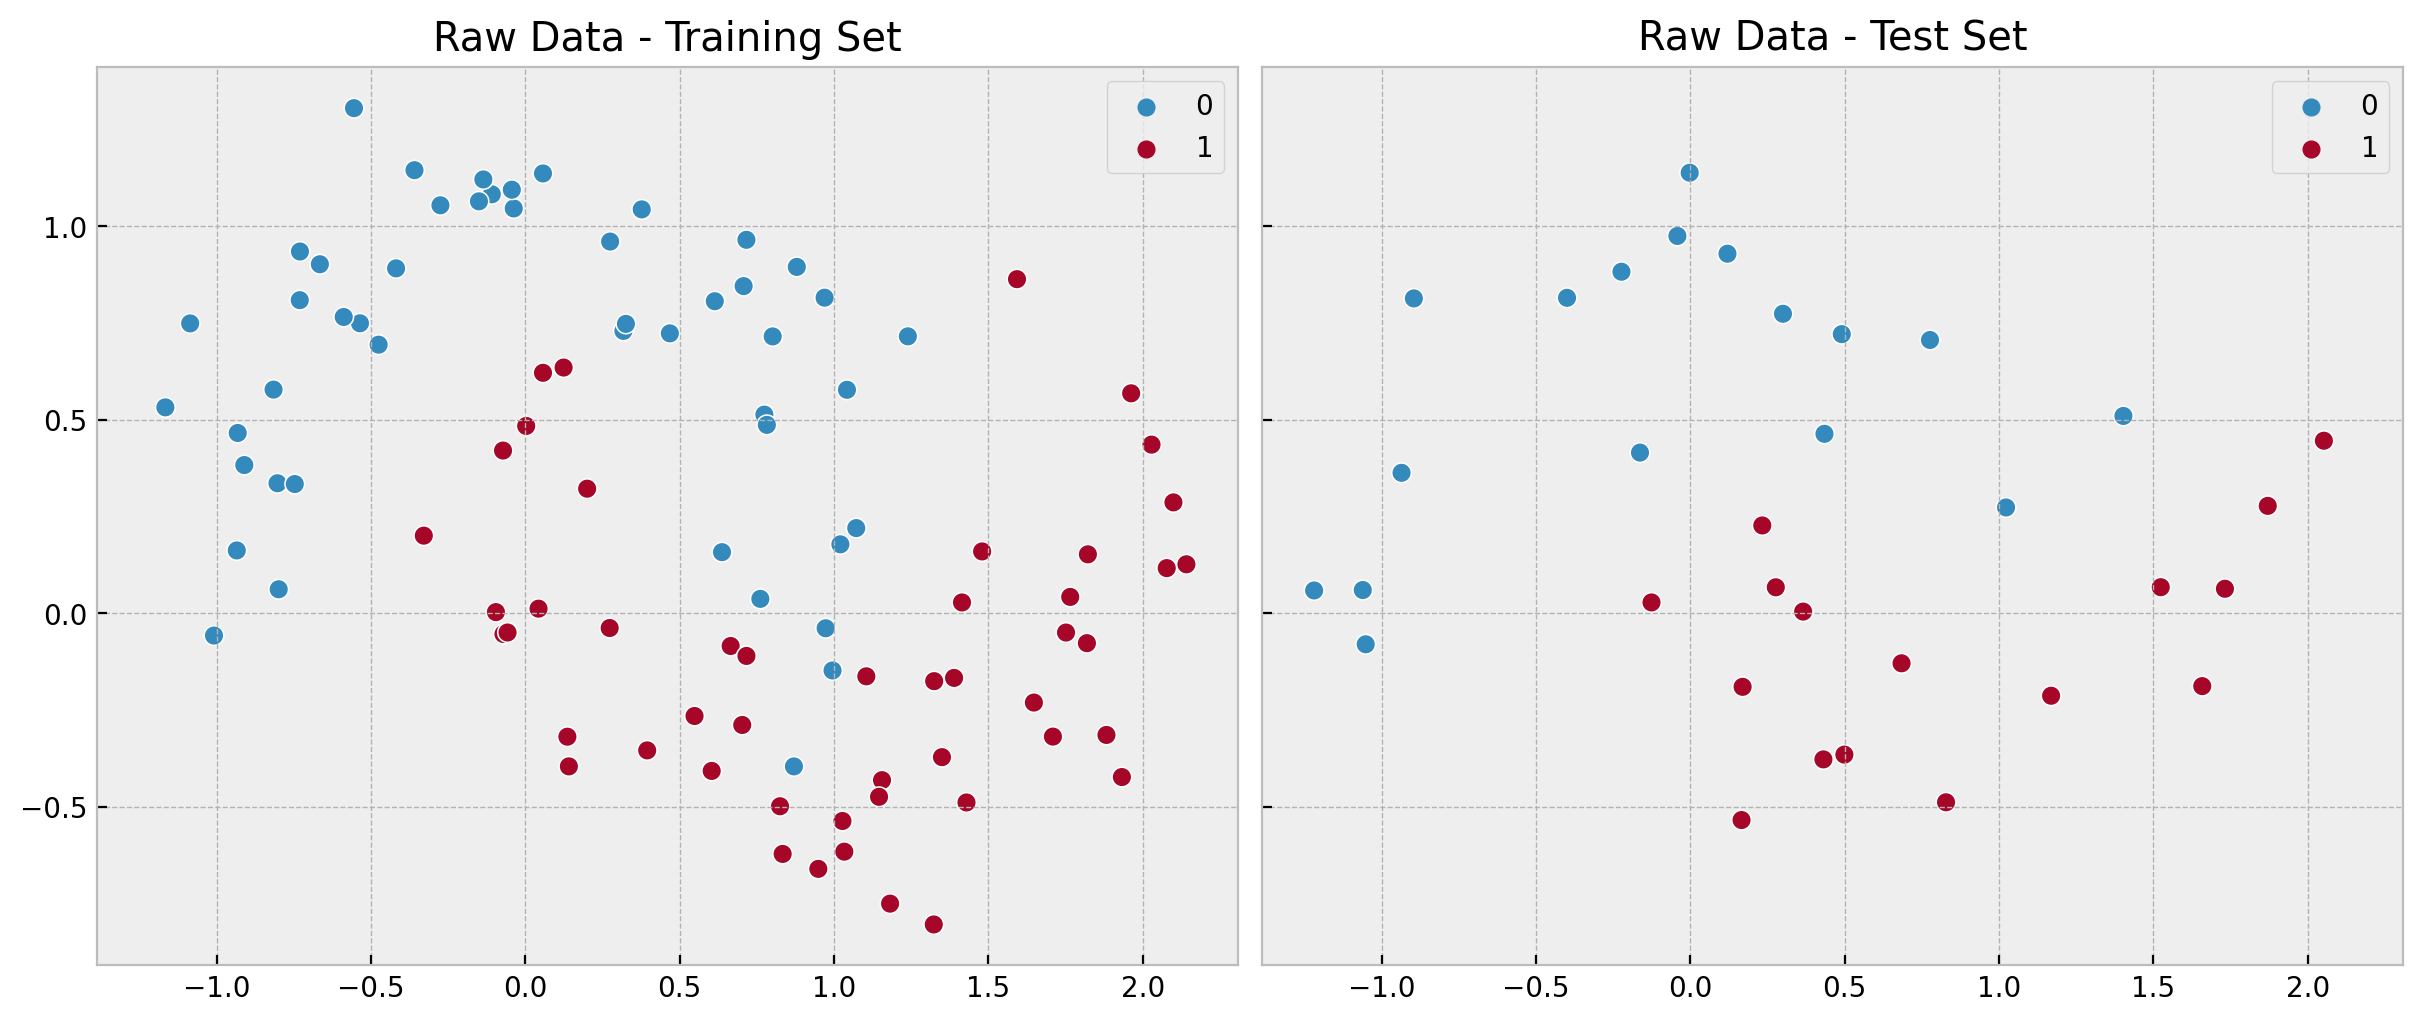

In [3]:
fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 5), sharex=True, sharey=True, layout="constrained"
)
sns.scatterplot(x=x_train[:, 0], y=x_train[:, 1], s=50, hue=y_train, ax=ax[0])
ax[0].set(title="Raw Data - Training Set")
sns.scatterplot(x=x_test[:, 0], y=x_test[:, 1], s=50, hue=y_test, ax=ax[1])
ax[1].set(title="Raw Data - Test Set");

We clearly see the non-linearity of pattern.

## Linear Model

First, we start with a simple linear model: Logistic Regression. Just because of the non-linearity of the data, we expect this model to perform poorly. Still, it serves as a baseline.

**Remark:** For details on the implementation, take a look into the slides of my talk [*Introduction to Bayesian Analysis with PyMC*](https://juanitorduz.github.io/html/pyconco22_orduz.html#/title-slide) at PyCon Colombia 2022. Moreover, please make sure you check out the [PyMC documentation](https://docs.pymc.io/) (specially the [examples](https://www.pymc.io/projects/examples/en/latest/gallery.html) section).

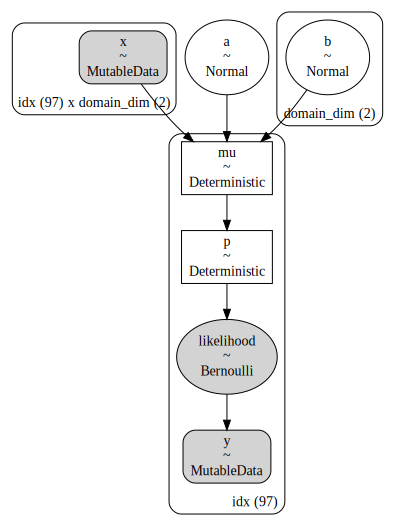

In [4]:
with pm.Model() as linear_model:
    # coordinates
    linear_model.add_coord(name="domain_dim", values=np.arange(domain_dim), mutable=False)
    linear_model.add_coord(name="idx", values=idx_train, mutable=True)
    # data containers
    x_ = pm.MutableData(name="x", value=x_train, dims=("idx", "domain_dim"))
    y_ = pm.MutableData(name="y", value=y_train, dims="idx")
    # priors
    a = pm.Normal(name="a", mu=0, sigma=2)
    b = pm.Normal(name="b", mu=0, sigma=2, dims="domain_dim")
    # model parametrization
    mu = pm.Deterministic(name="mu", var=pm.math.dot(x_, b) + a, dims="idx")
    p = pm.Deterministic(name="p", var=pm.math.invlogit(mu), dims="idx")
    # likelihood
    likelihood = pm.Bernoulli(name="likelihood", p=p, dims="idx", observed=y_)

pm.model_to_graphviz(model=linear_model)

We now fit the model.

In [5]:
with linear_model:
    linear_idata = pm.sampling_jax.sample_numpyro_nuts(draws=4000, chains=4)
    linear_posterior_predictive = pm.sample_posterior_predictive(trace=linear_idata)

Compiling...
Compilation time =  0:00:02.341218
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:00:03.367646
Transforming variables...
Transformation time =  0:00:00.228486
Computing Log Likelihood...
Log Likelihood time =  0:00:00.634767


Le'ts look into some model diagnostics:

In [6]:
az.summary(data=linear_idata, var_names=["a", "b"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.300,0.405,-0.461,1.065,0.004,0.003,8978.0,9126.0,1.0
b[0],1.155,0.367,0.504,1.881,0.004,0.003,9758.0,8973.0,1.0
b[1],-3.303,0.689,-4.601,-2.016,0.007,0.005,9456.0,9822.0,1.0


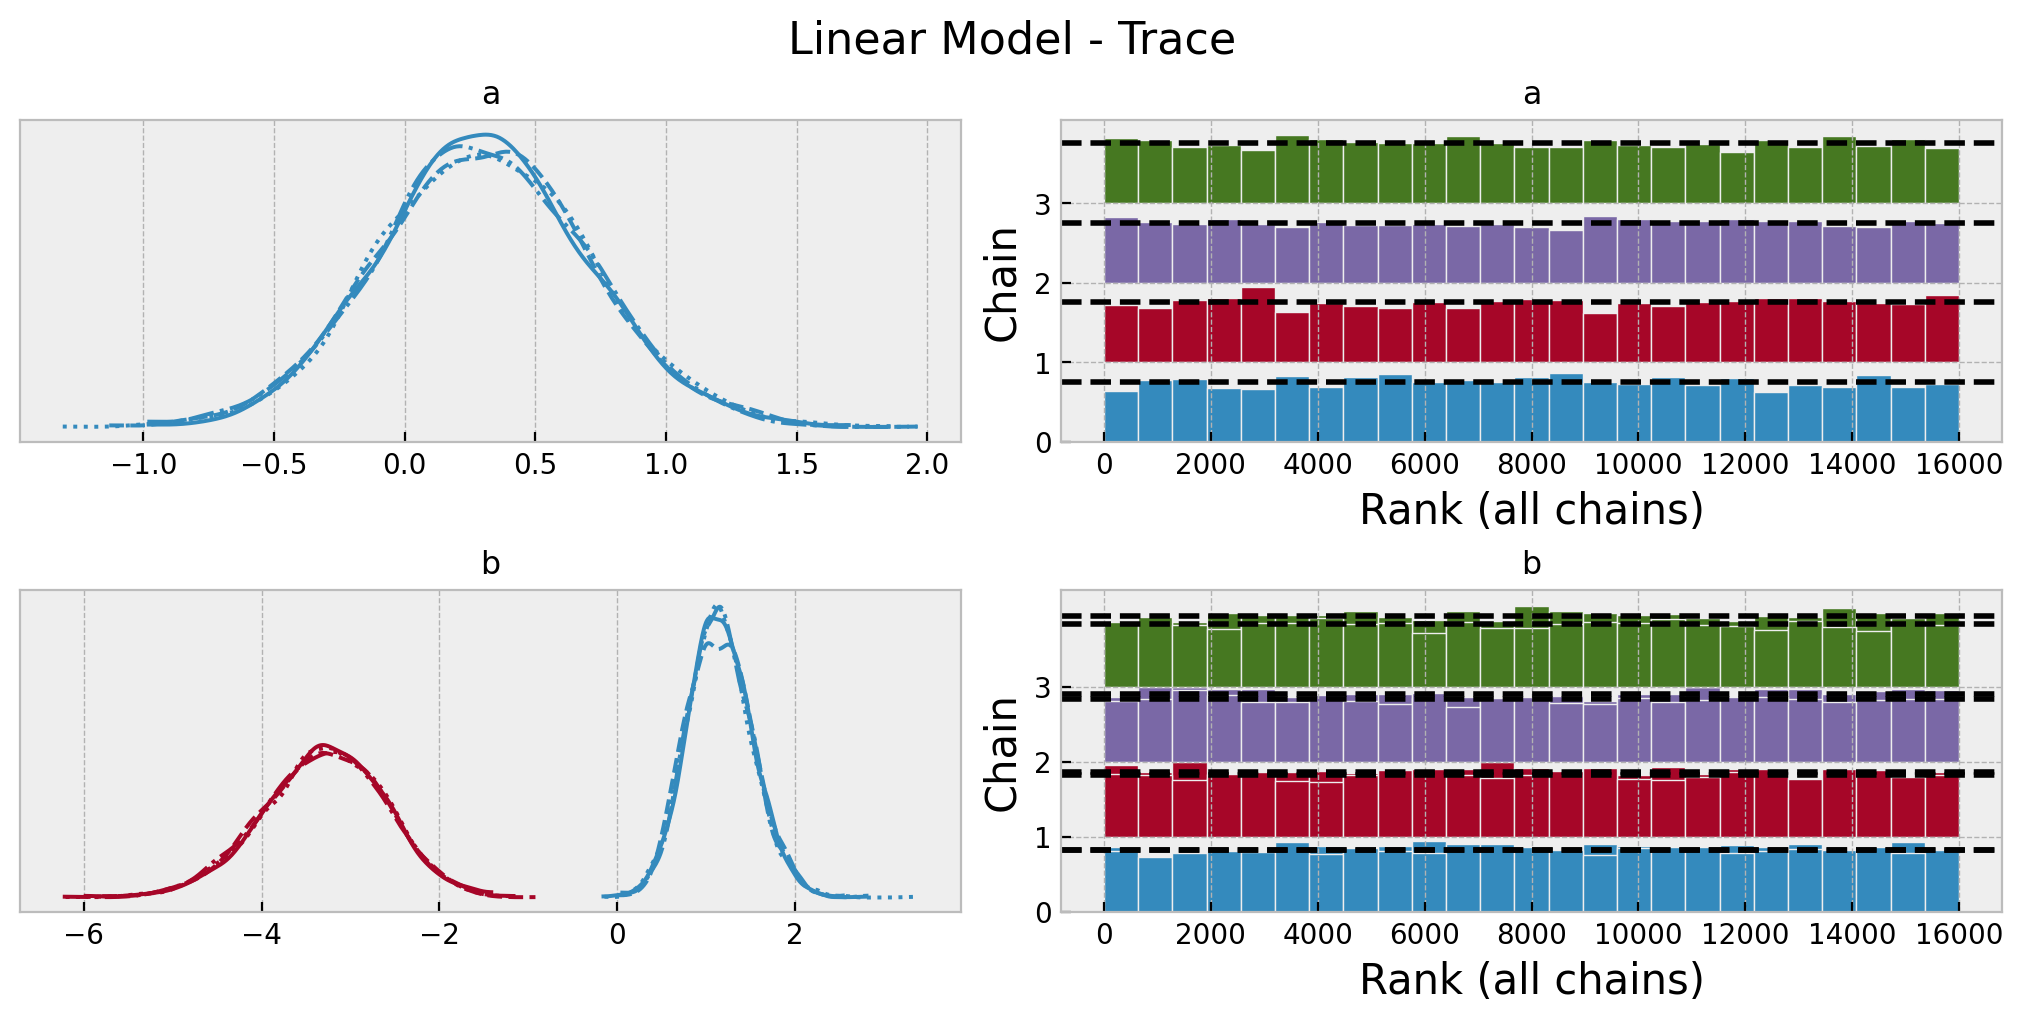

In [7]:
axes = az.plot_trace(
    data=linear_idata,
    var_names=["a", "b"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 5), "layout": "constrained"},
)
plt.gcf().suptitle("Linear Model - Trace", fontsize=16);

Next, we generate out-of-sample predictions.

In [8]:
with linear_model:
    pm.set_data(new_data={"x": x_test, "y": y_test}, coords={"idx": idx_test})
    linear_idata.extend(
        other=pm.sample_posterior_predictive(
            trace=linear_idata,
            var_names=["likelihood", "p"],
            idata_kwargs={"coords": {"idx": idx_test}},
        ),
        join="right",
    )

We can now compare the model in-sample and out-of-sample performance.

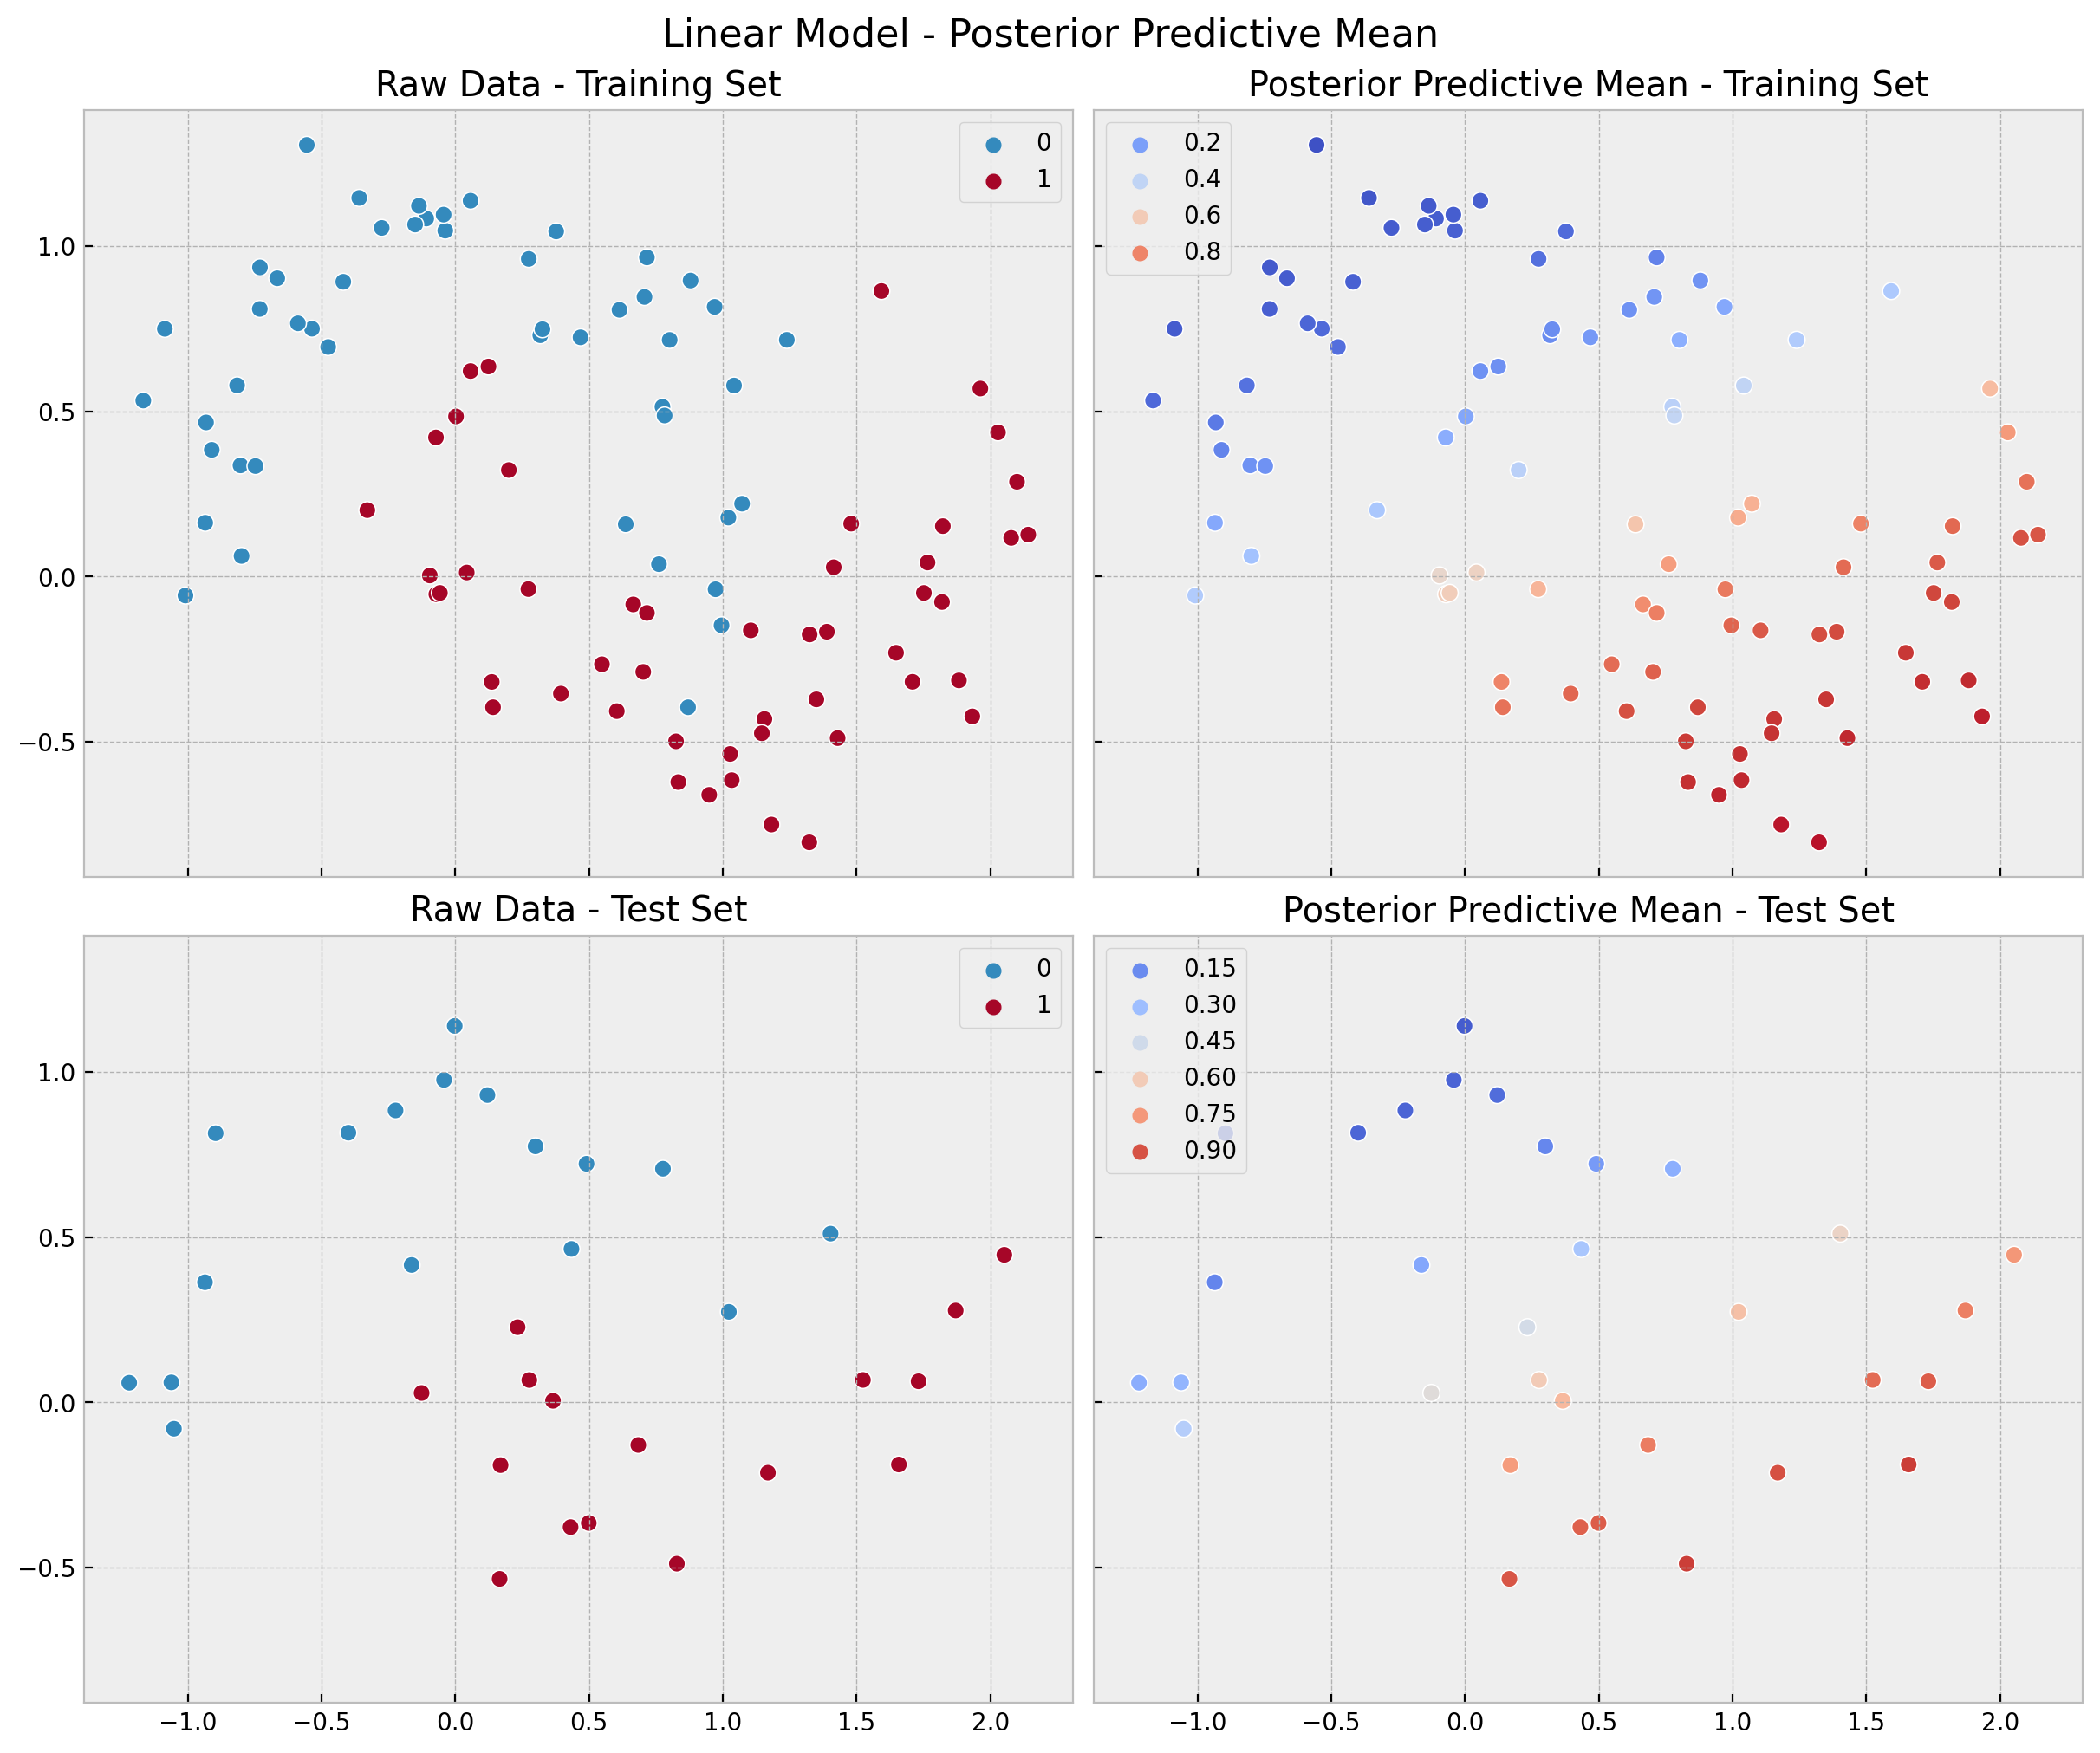

In [9]:
linear_posterior_predictive_mean_train = (
    linear_posterior_predictive.posterior_predictive["likelihood"]
    .stack(sample=("chain", "draw"))
    .mean(axis=1)
)

linear_posterior_predictive_mean_test = (
    linear_idata.posterior_predictive["likelihood"]
    .stack(sample=("chain", "draw"))
    .mean(axis=1)
)

fig, ax = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 10), sharex=True, sharey=True, layout="constrained"
)

sns.scatterplot(x=x_train[:, 0], y=x_train[:, 1], s=50, hue=y_train, ax=ax[0, 0])
ax[0, 0].set(title="Raw Data - Training Set")

sns.scatterplot(
    x=x_train[:, 0],
    y=x_train[:, 1],
    s=50,
    hue=linear_posterior_predictive_mean_train,
    hue_norm=(0, 1),
    palette="coolwarm",
    ax=ax[0, 1],
)
ax[0, 1].legend(loc="upper left")
ax[0, 1].set(title="Posterior Predictive Mean - Training Set")

sns.scatterplot(x=x_test[:, 0], y=x_test[:, 1], s=50, hue=y_test, ax=ax[1, 0])
ax[1, 0].set(title="Raw Data - Test Set")

sns.scatterplot(
    x=x_test[:, 0],
    y=x_test[:, 1],
    s=50,
    hue=linear_posterior_predictive_mean_test,
    hue_norm=(0, 1),
    palette="coolwarm",
    ax=ax[1, 1],
)
ax[1, 1].legend(loc="upper left")
ax[1, 1].set(title="Posterior Predictive Mean - Test Set")
fig.suptitle("Linear Model - Posterior Predictive Mean", fontsize=16);

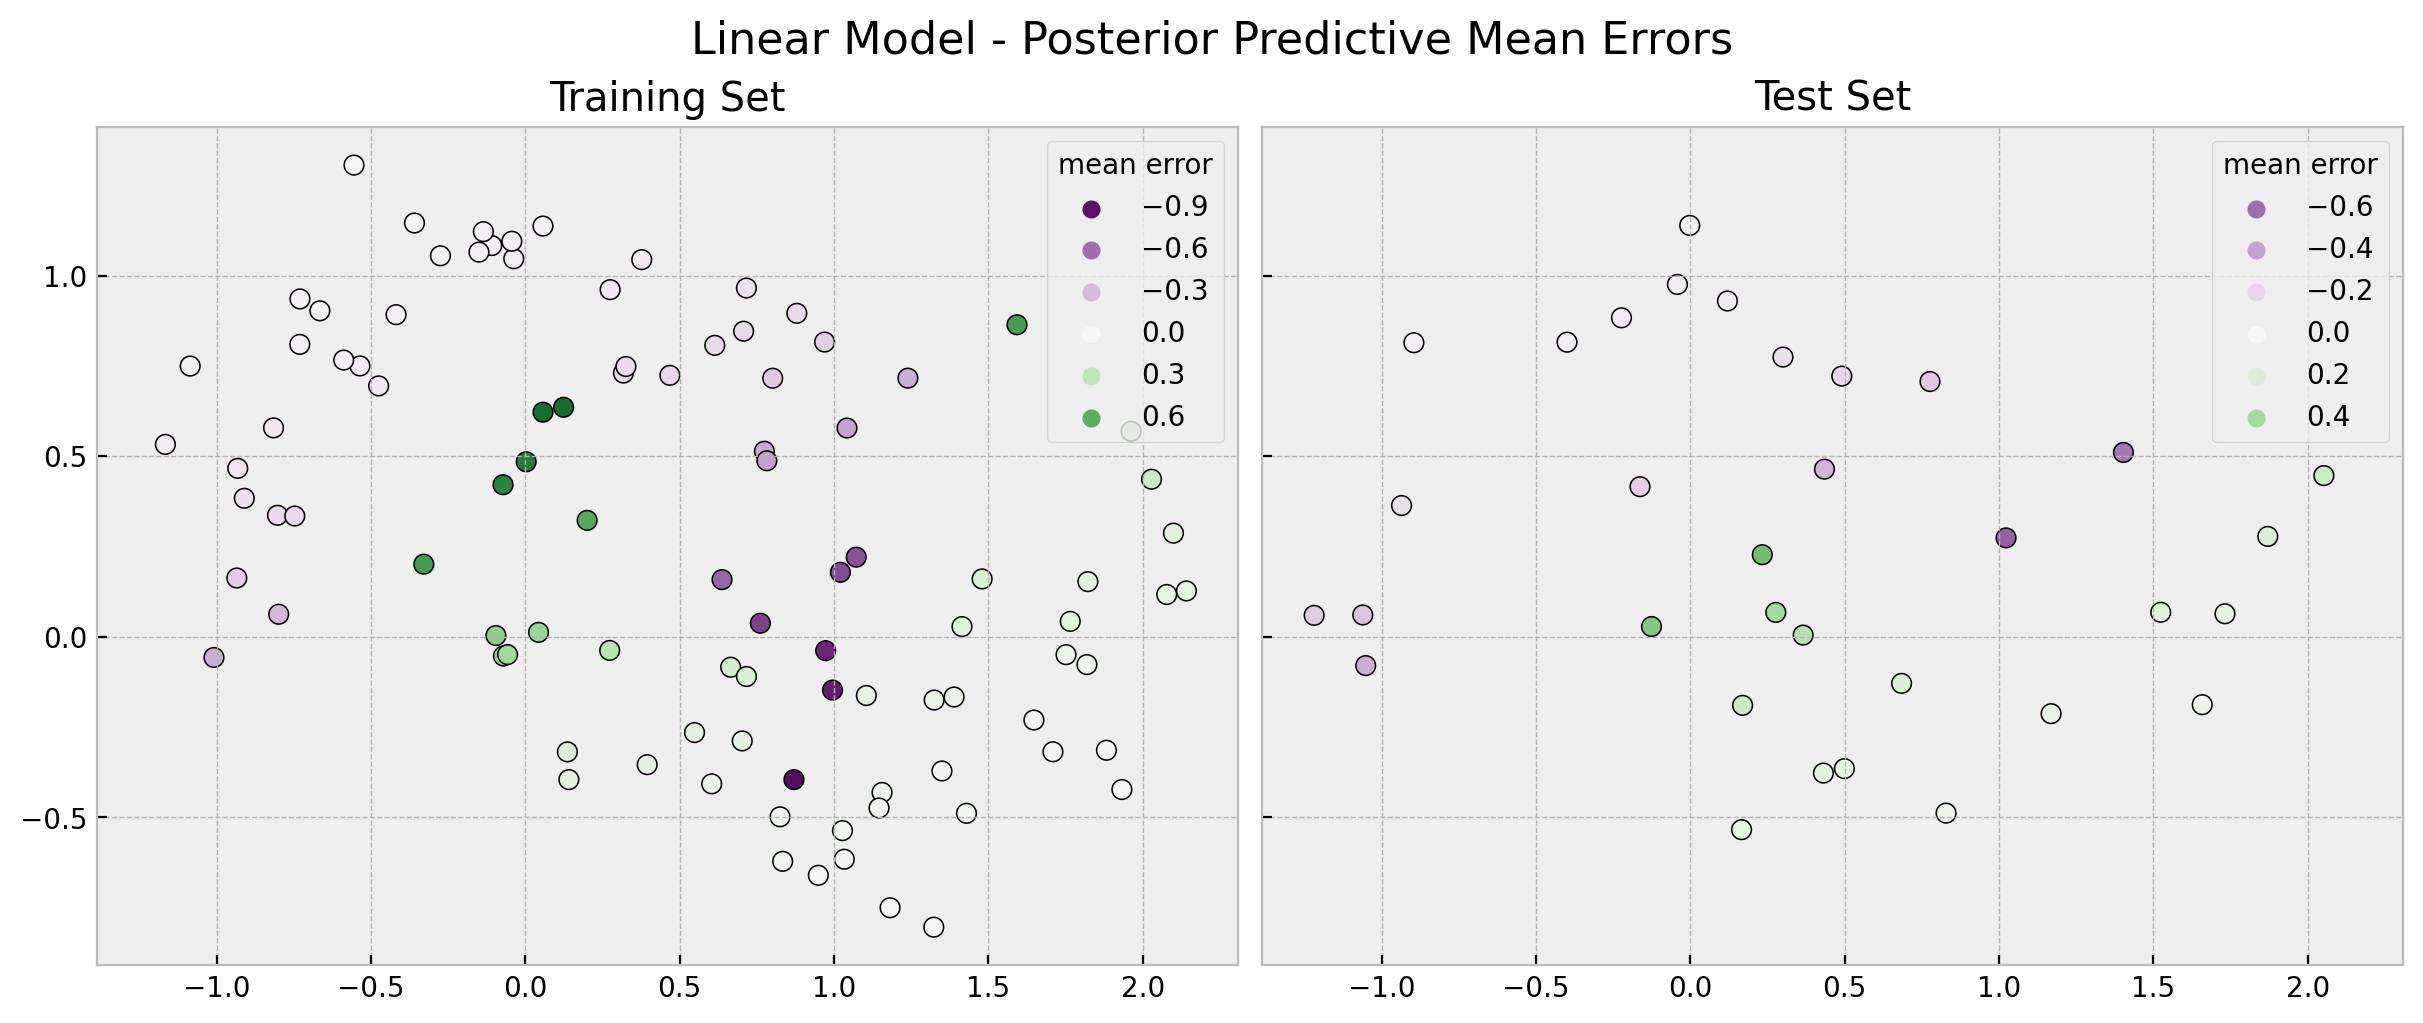

In [10]:
linear_errors_mean_train = (
    y_train[..., None]
    - linear_posterior_predictive.posterior_predictive["likelihood"].stack(
        sample=("chain", "draw")
    )
).mean(axis=1)

linear_errors_mean_test = (
    y_test[..., None]
    - linear_idata.posterior_predictive["likelihood"].stack(sample=("chain", "draw"))
).mean(axis=1)

fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 5), sharex=True, sharey=True, layout="constrained"
)
sns.scatterplot(
    x=x_train[:, 0],
    y=x_train[:, 1],
    s=50,
    edgecolor="black",
    hue=linear_errors_mean_train,
    hue_norm=(-1, 1),
    palette="PRGn",
    ax=ax[0],
)
ax[0].legend(title="mean error")
ax[0].set(title="Training Set")

sns.scatterplot(
    x=x_test[:, 0],
    y=x_test[:, 1],
    s=50,
    edgecolor="black",
    hue=linear_errors_mean_test,
    hue_norm=(-1, 1),
    palette="PRGn",
    ax=ax[1],
)
ax[1].legend(title="mean error")
ax[1].set(title="Test Set")
fig.suptitle("Linear Model - Posterior Predictive Mean Errors", fontsize=16);

It is also interesting to compare the $94\%$ [HDI](https://arviz-devs.github.io/arviz/api/generated/arviz.hdi.html) (highest density interval) interval of the errors distribution obtained from the posterior mean.

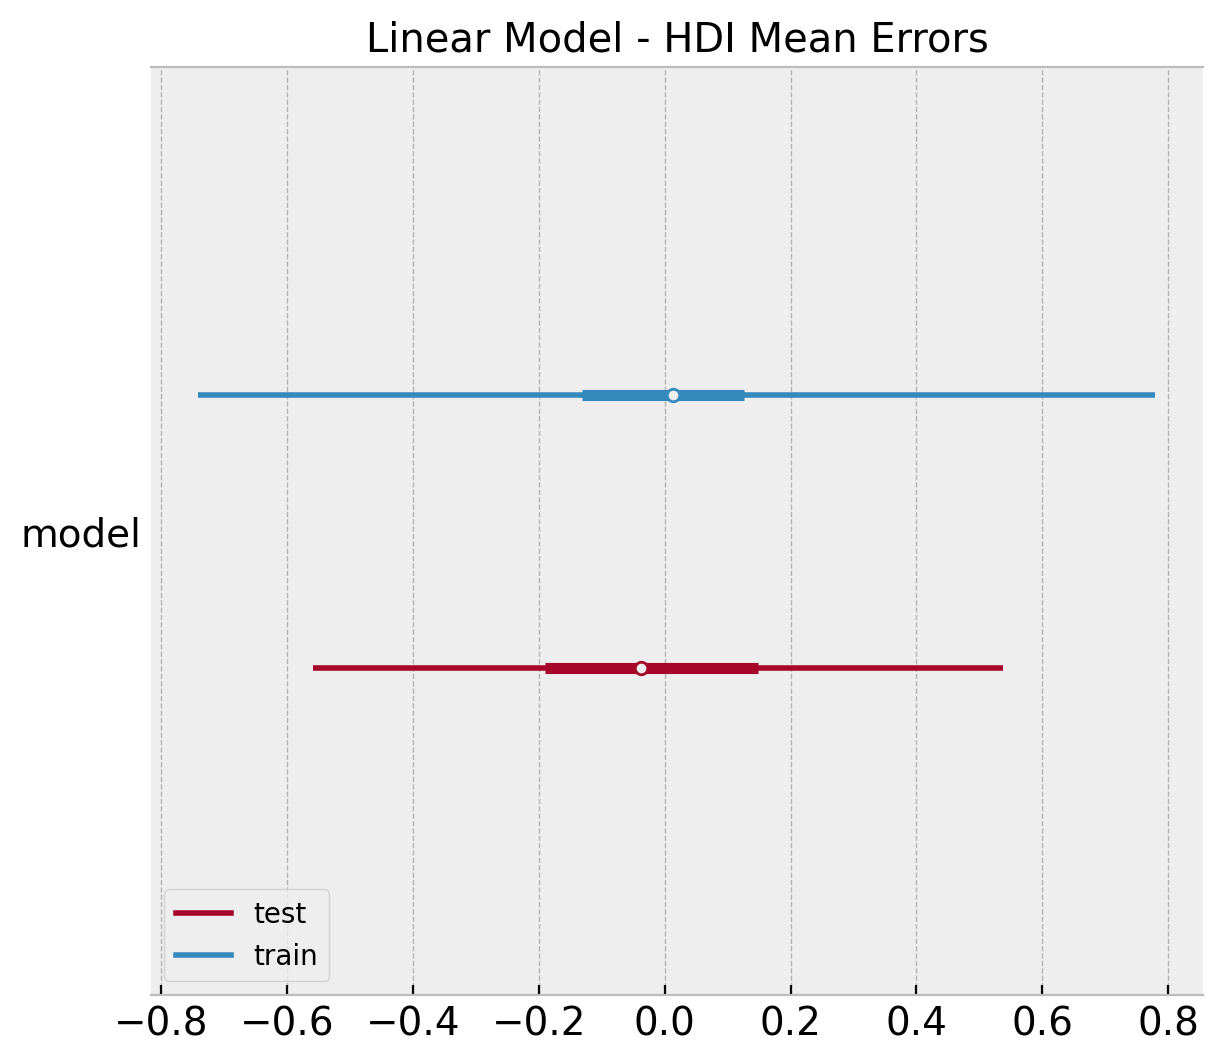

In [11]:
ax, *_ = az.plot_forest(
    [
        az.convert_to_dataset(obj={"model": linear_errors_mean_train}),
        az.convert_to_dataset(obj={"model": linear_errors_mean_test}),
    ],
    model_names=["train", "test"],
    backend_kwargs={"layout": "constrained"},
)
ax.set(title="Linear Model - HDI Mean Errors");

Finally, we compute the $94/%$ [HDI](https://arviz-devs.github.io/arviz/api/generated/arviz.hdi.html) of accuracy distribution. 

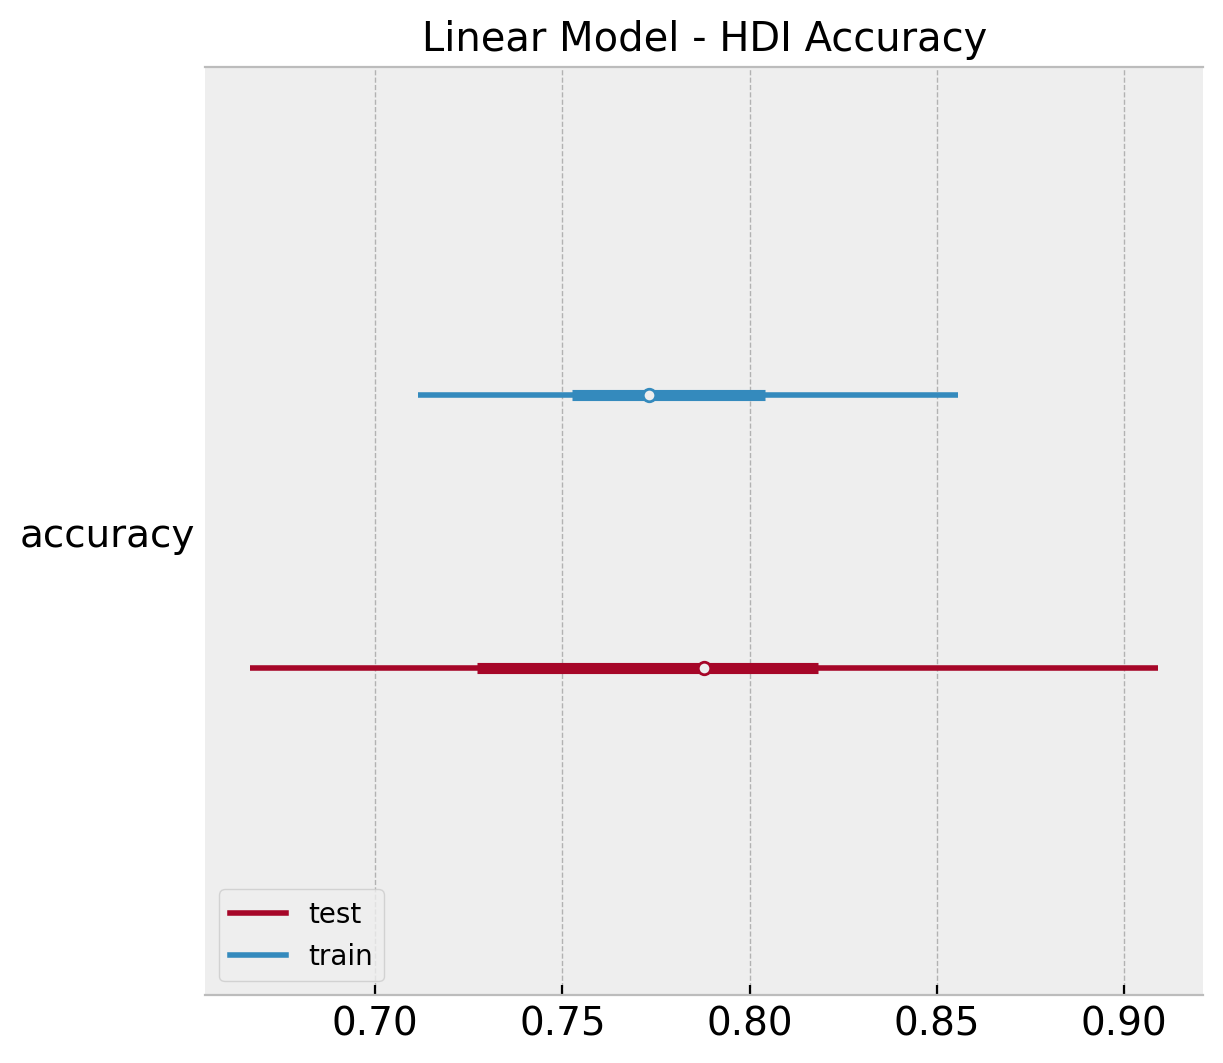

In [12]:
linear_acc_samples_train = np.apply_along_axis(
    func1d=lambda x: accuracy_score(y_true=y_train, y_pred=x),
    axis=0,
    arr=linear_posterior_predictive
    .posterior_predictive
    ["likelihood"]
    .stack(sample=("chain", "draw"))
)

linear_acc_samples_test = np.apply_along_axis(
    func1d=lambda x: accuracy_score(y_true=y_test, y_pred=x),
    axis=0,
    arr=linear_idata
    .posterior_predictive
    ["likelihood"]
    .stack(sample=("chain", "draw"))
)


ax, *_ = az.plot_forest(
    [
        az.convert_to_dataset(obj={"accuracy": linear_acc_samples_train}),
        az.convert_to_dataset(obj={"accuracy": linear_acc_samples_test}),
    ],
    model_names=["train", "test"],
    backend_kwargs={"layout": "constrained"},
)
ax.set(title="Linear Model - HDI Accuracy");

## Gaussian Process

To account for non-linearity, we now fit a Gaussian Process Classifier. For more details about gaussian processes, please check out the [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/chapters/RW.pdf) book by Rasmussen and Williams. If you are interested in a more practical introduction you can take a look into a couple of blog posts [Bayesian Regression as a Gaussian Process](https://juanitorduz.github.io/reg_bayesian_regression/) and [An Introduction to Gaussian Process Regression](https://juanitorduz.github.io/gaussian_process_reg/).

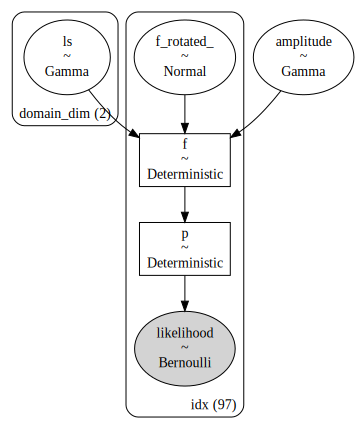

In [13]:
with pm.Model(coords={"domain_dim": range(domain_dim)}) as gp_model:

    gp_model.add_coord(name="idx", values=idx_train, mutable=True)

    ls = pm.Gamma(name="ls", alpha=2, beta=1, dims="domain_dim")
    amplitude = pm.Gamma(name="amplitude", alpha=2, beta=1)
    cov = amplitude ** 2 * pm.gp.cov.ExpQuad(input_dim=2, ls=ls)

    gp= pm.gp.Latent(cov_func=cov)
    f = gp.prior(name="f", X=x_train, dims="idx")
    p = pm.Deterministic(name="p", var=pm.math.invlogit(f), dims="idx")
    # likelihood
    likelihood = pm.Bernoulli(name="likelihood", p=p, dims="idx", observed=y_train)

pm.model_to_graphviz(model=gp_model)

We now fit the model.

In [14]:
with gp_model:
    gp_idata = pm.sampling_jax.sample_numpyro_nuts(draws=4000, chains=4)
    gp_posterior_predictive = pm.sample_posterior_predictive(trace=gp_idata)

Compiling...
Compilation time =  0:00:02.278451
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:03:12.600007
Transforming variables...
Transformation time =  0:00:28.507063
Computing Log Likelihood...
Log Likelihood time =  0:00:20.961072


Again, we look into some model diagnostics:

In [15]:
az.summary(data=gp_idata, var_names=["ls", "amplitude"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ls[0],0.551,0.122,0.327,0.781,0.002,0.001,6315.0,7042.0,1.0
ls[1],1.126,0.429,0.466,1.933,0.006,0.004,4989.0,8604.0,1.0
amplitude,6.767,2.025,3.412,10.657,0.019,0.013,12098.0,12052.0,1.0


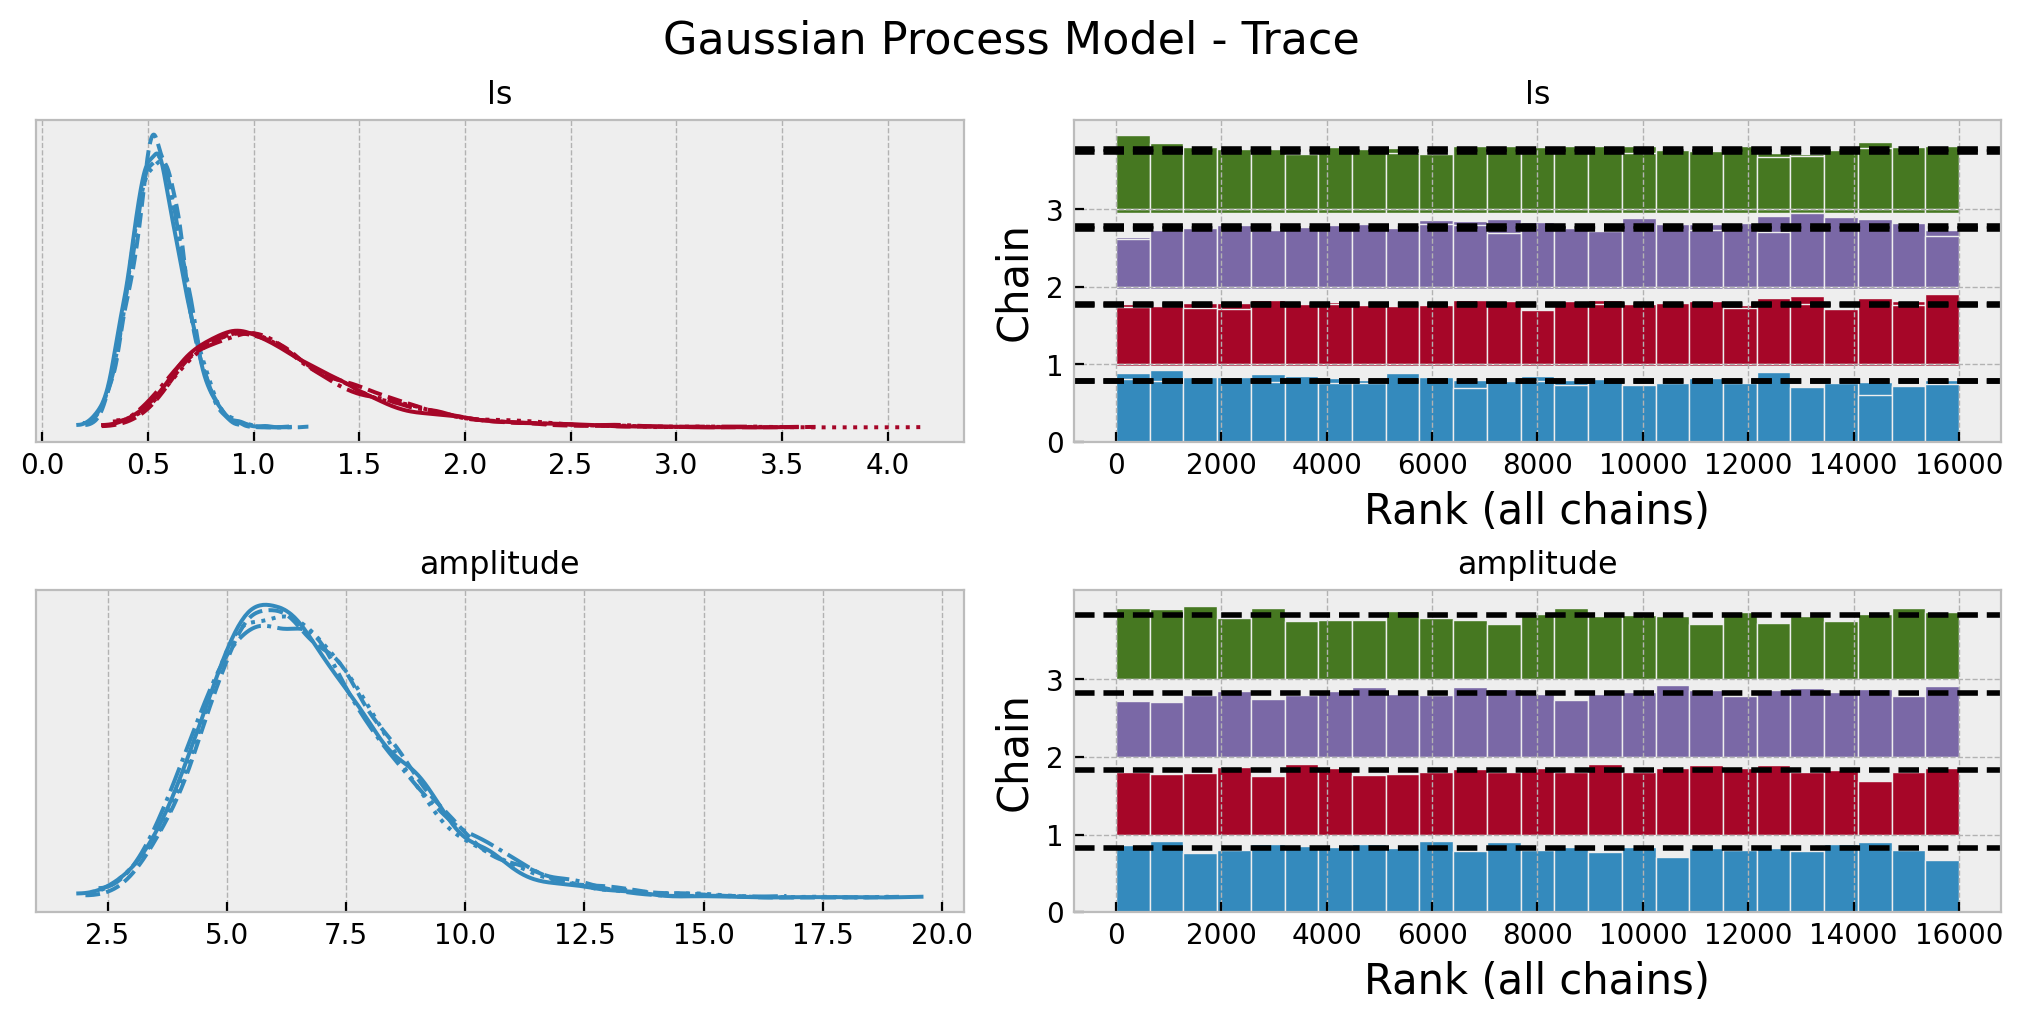

In [16]:
axes = az.plot_trace(
    data=gp_idata,
    var_names=["ls", "amplitude"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 5), "layout": "constrained"},
)
plt.gcf().suptitle("Gaussian Process Model - Trace", fontsize=16);

In order to generate out-of-sample predictions, we need to use the `.conditional` method (see [Latent Variable Implementation](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-Latent.html)) to get posterior predictive samples of the latent variable `f`. Then, we simply pass it through the `invlink` function to get the posterior predictive samples of the class probabilities.

In [17]:
with gp_model:
    f_pred = gp.conditional(name="f_pred", Xnew=x_test)
    gp_posterior_predictive_test = pm.sample_posterior_predictive(trace=gp_idata, var_names=["f_pred"])

gp_pred_test = expit(gp_posterior_predictive_test.posterior_predictive["f_pred"].stack(sample=("chain", "draw")))
gp_pred_test = np.random.binomial(n=1, p=gp_pred_test)

Finally, we compute and visualize the predictions, errors and accuracy distributions.

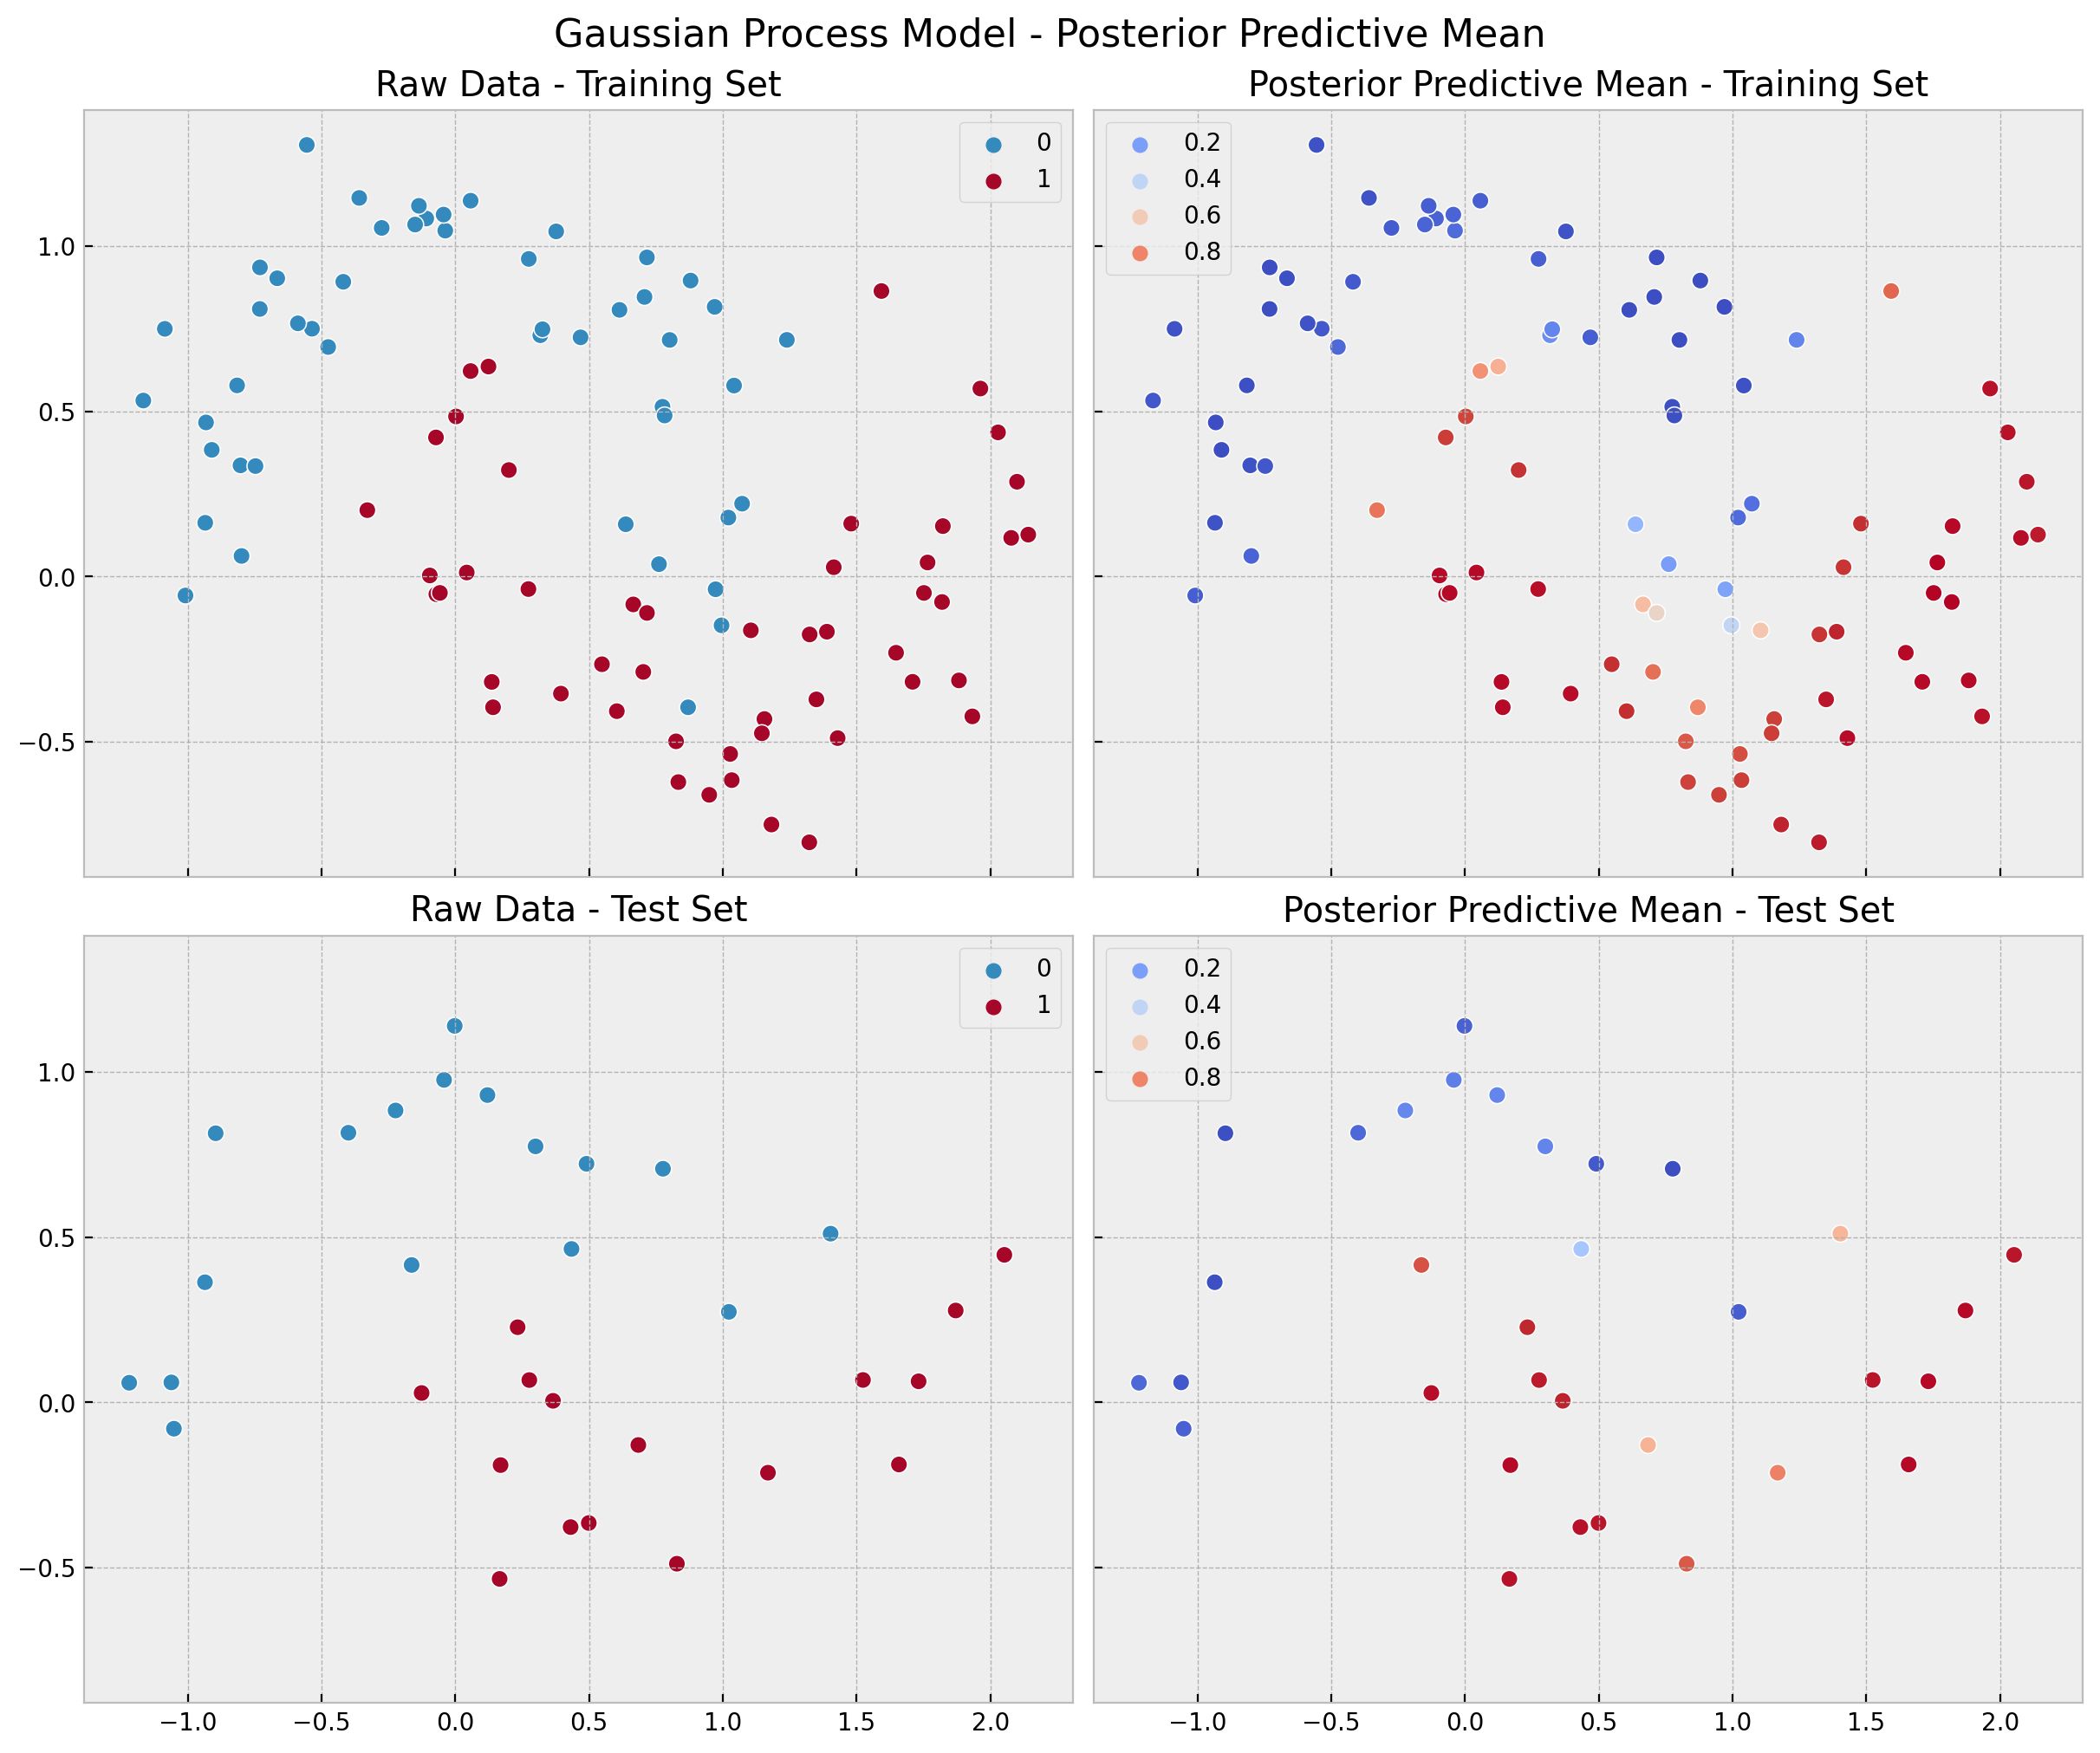

In [18]:
gp_posterior_predictive_mean_train = (
    gp_posterior_predictive.posterior_predictive["likelihood"]
    .stack(sample=("chain", "draw"))
    .mean(axis=1)
)

gp_posterior_predictive_mean_test = gp_pred_test.mean(axis=1) 

fig, ax = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 10), sharex=True, sharey=True, layout="constrained"
)

sns.scatterplot(x=x_train[:, 0], y=x_train[:, 1], s=50, hue=y_train, ax=ax[0, 0])
ax[0, 0].set(title="Raw Data - Training Set")

sns.scatterplot(
    x=x_train[:, 0],
    y=x_train[:, 1],
    s=50,
    hue=gp_posterior_predictive_mean_train,
    hue_norm=(0, 1),
    palette="coolwarm",
    ax=ax[0, 1],
)
ax[0, 1].legend(loc="upper left")
ax[0, 1].set(title="Posterior Predictive Mean - Training Set")

sns.scatterplot(x=x_test[:, 0], y=x_test[:, 1], s=50, hue=y_test, ax=ax[1, 0])
ax[1, 0].set(title="Raw Data - Test Set")

sns.scatterplot(
    x=x_test[:, 0],
    y=x_test[:, 1],
    s=50,
    hue=gp_posterior_predictive_mean_test,
    hue_norm=(0, 1),
    palette="coolwarm",
    ax=ax[1, 1],
)
ax[1, 1].legend(loc="upper left")
ax[1, 1].set(title="Posterior Predictive Mean - Test Set")
fig.suptitle("Gaussian Process Model - Posterior Predictive Mean", fontsize=16);

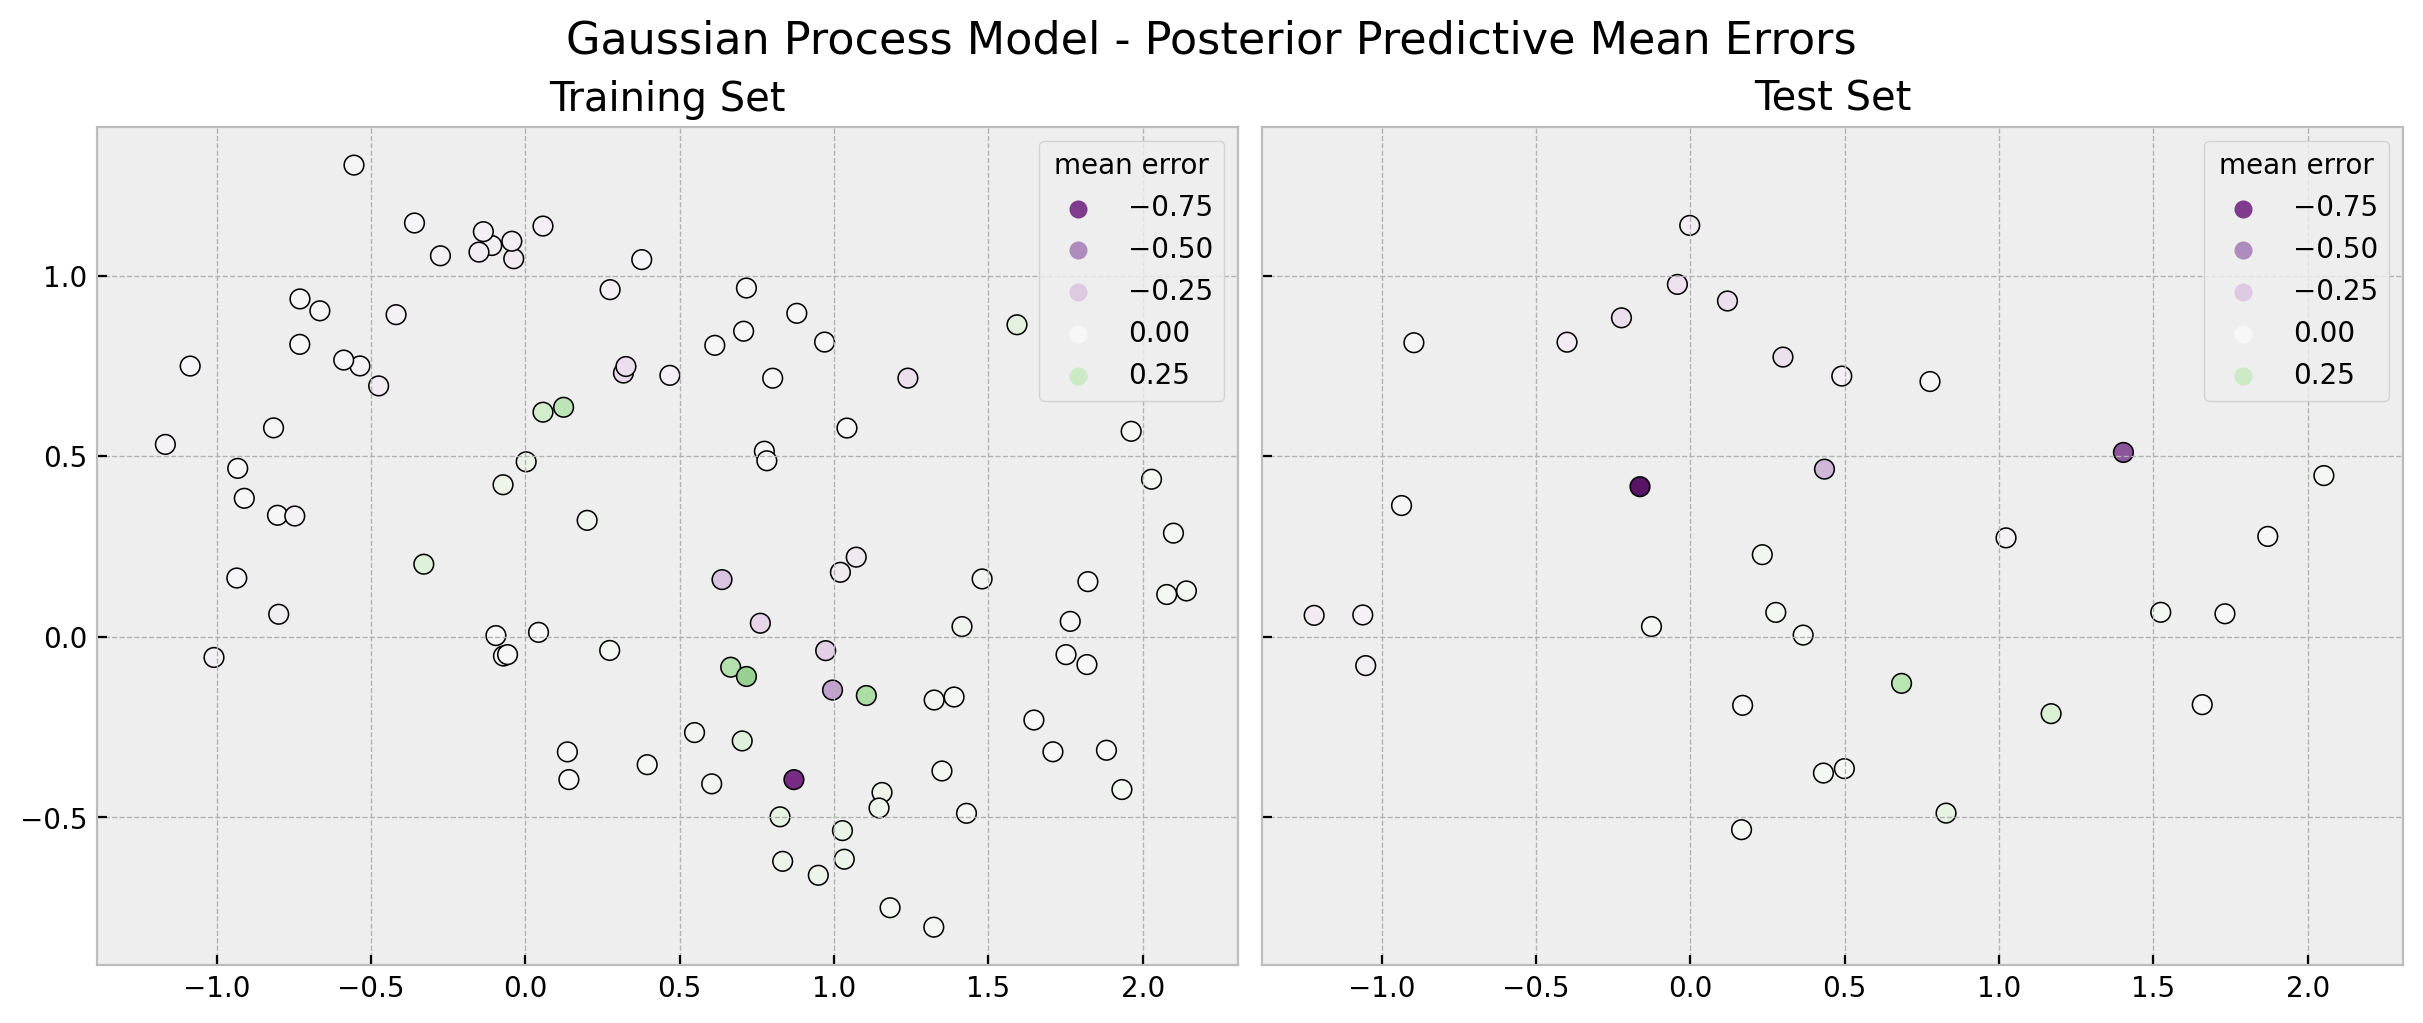

In [19]:
gp_errors_mean_train = (
    y_train[..., None]
    - gp_posterior_predictive.posterior_predictive["likelihood"].stack(
        sample=("chain", "draw")
    )
).mean(axis=1)

gp_errors_mean_test = (y_test[..., None] - gp_pred_test).mean(axis=1)

fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 5), sharex=True, sharey=True, layout="constrained"
)
sns.scatterplot(
    x=x_train[:, 0],
    y=x_train[:, 1],
    s=50,
    edgecolor="black",
    hue=gp_errors_mean_train,
    hue_norm=(-1, 1),
    palette="PRGn",
    ax=ax[0],
)
ax[0].legend(title="mean error")
ax[0].set(title="Training Set")

sns.scatterplot(
    x=x_test[:, 0],
    y=x_test[:, 1],
    s=50,
    edgecolor="black",
    hue=gp_errors_mean_test,
    hue_norm=(-1, 1),
    palette="PRGn",
    ax=ax[1],
)
ax[1].legend(title="mean error")
ax[1].set(title="Test Set")
fig.suptitle("Gaussian Process Model - Posterior Predictive Mean Errors", fontsize=16);

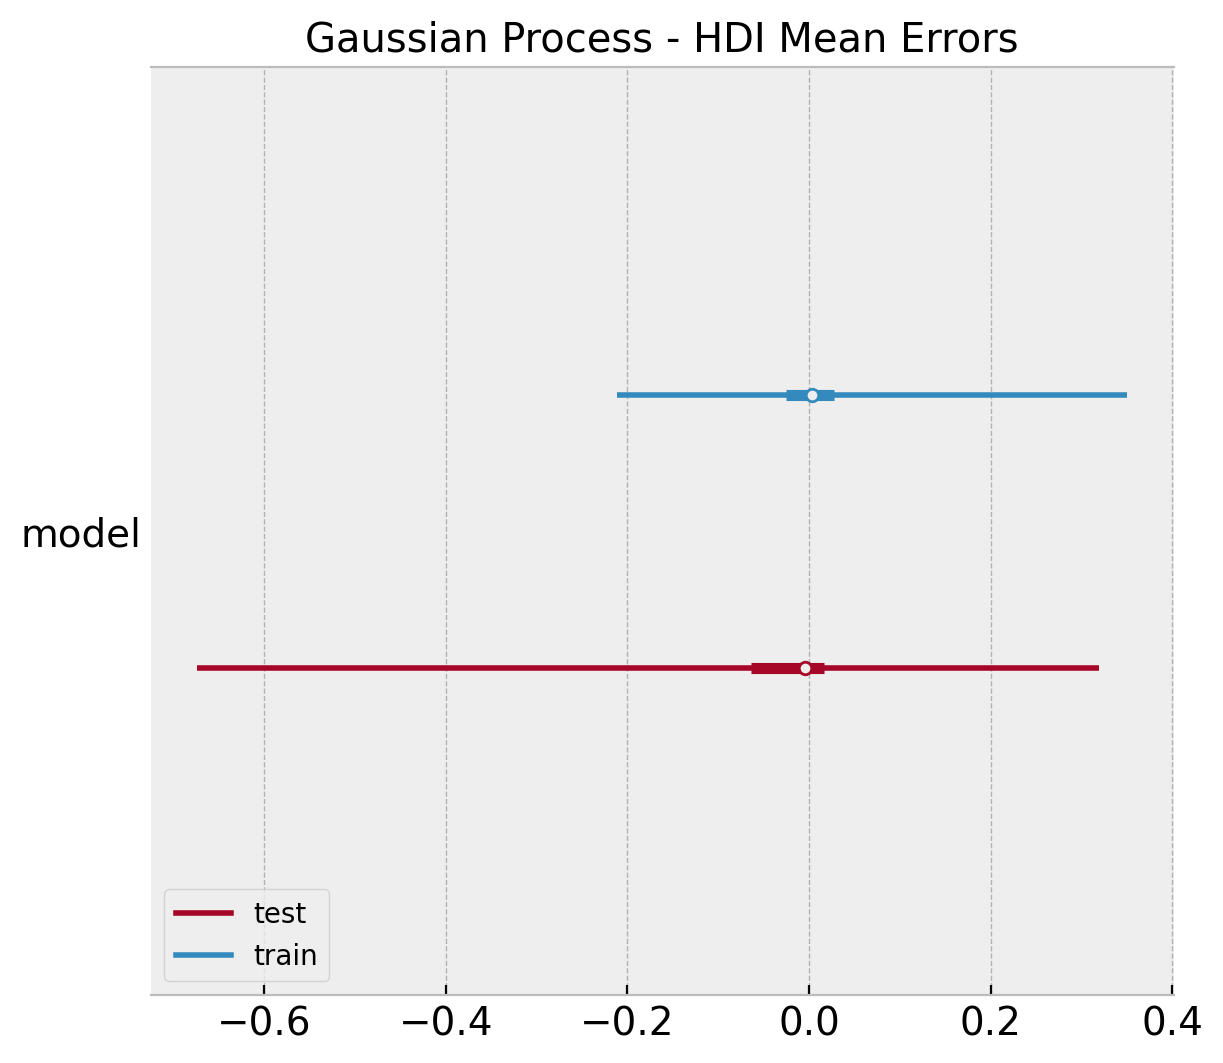

In [20]:
ax, *_ = az.plot_forest(
    [
        az.convert_to_dataset(obj={"model": gp_errors_mean_train}),
        az.convert_to_dataset(obj={"model": gp_errors_mean_test}),
    ],
    model_names=["train", "test"],
    backend_kwargs={"layout": "constrained"},
)
ax.set(title="Gaussian Process - HDI Mean Errors");

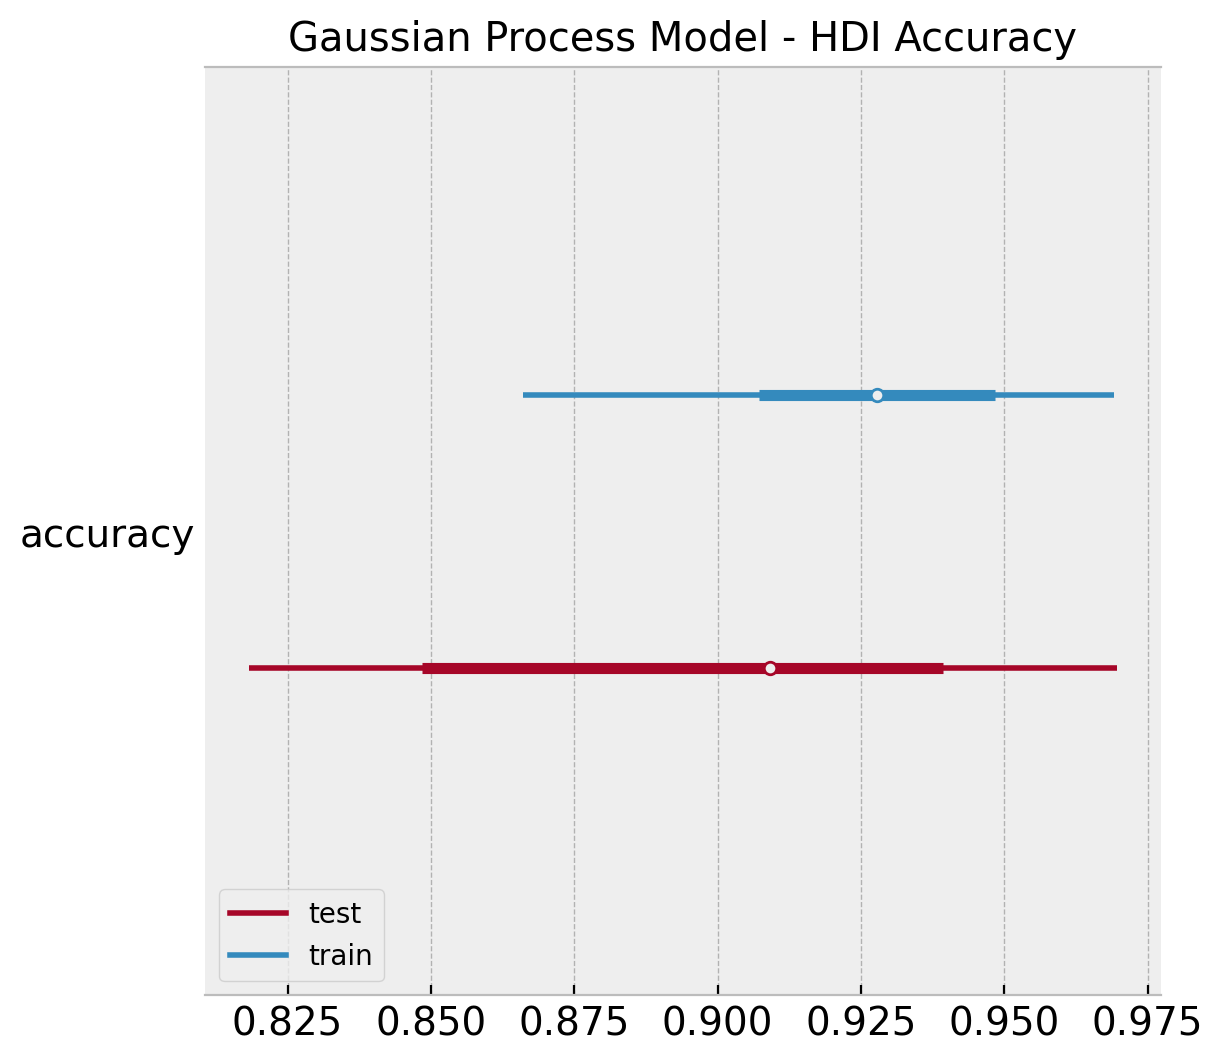

In [21]:
gp_acc_samples_train = np.apply_along_axis(
    func1d=lambda x: accuracy_score(y_true=y_train, y_pred=x),
    axis=0,
    arr=gp_posterior_predictive
    .posterior_predictive
    ["likelihood"]
    .stack(sample=("chain", "draw"))
    .to_numpy()
)

gp_acc_samples_test = np.apply_along_axis(
    func1d=lambda x: accuracy_score(y_true=y_test, y_pred=x),
    axis=0,
    arr=gp_pred_test
)

ax, *_ = az.plot_forest(
    [
        az.convert_to_dataset(obj={"accuracy": gp_acc_samples_train}),
        az.convert_to_dataset(obj={"accuracy": gp_acc_samples_test}),
    ],
    model_names=["train", "test"],
    backend_kwargs={"layout": "constrained"},
)
ax.set(title="Gaussian Process Model - HDI Accuracy");

## Model Comparison

By looking into the plots above we clearly see that the gaussian process model is a better model for this non-linear data. In this last section we hand to dig a bit deeper into model comparison. First, let's look into the [`plot_separation`](https://arviz-devs.github.io/arviz/examples/plot_separation.html) function from [`arviz`](https://arviz-devs.github.io/arviz/). According to the authors of the method:

>*It is a visual method for assessing the predictive power of models with binary outcomes. This technique allows the analyst to evaluate model fit based upon the models’ ability to consistently match high-probability predictions to actual occurrences of the event of interest, and low-probability predictions to nonoccurrences of the event of interest.*

For more details see [The Separation Plot: A New Visual Method for Evaluating the Fit of Binary Models](https://onlinelibrary.wiley.com/doi/10.1111/j.1540-5907.2011.00525.x))

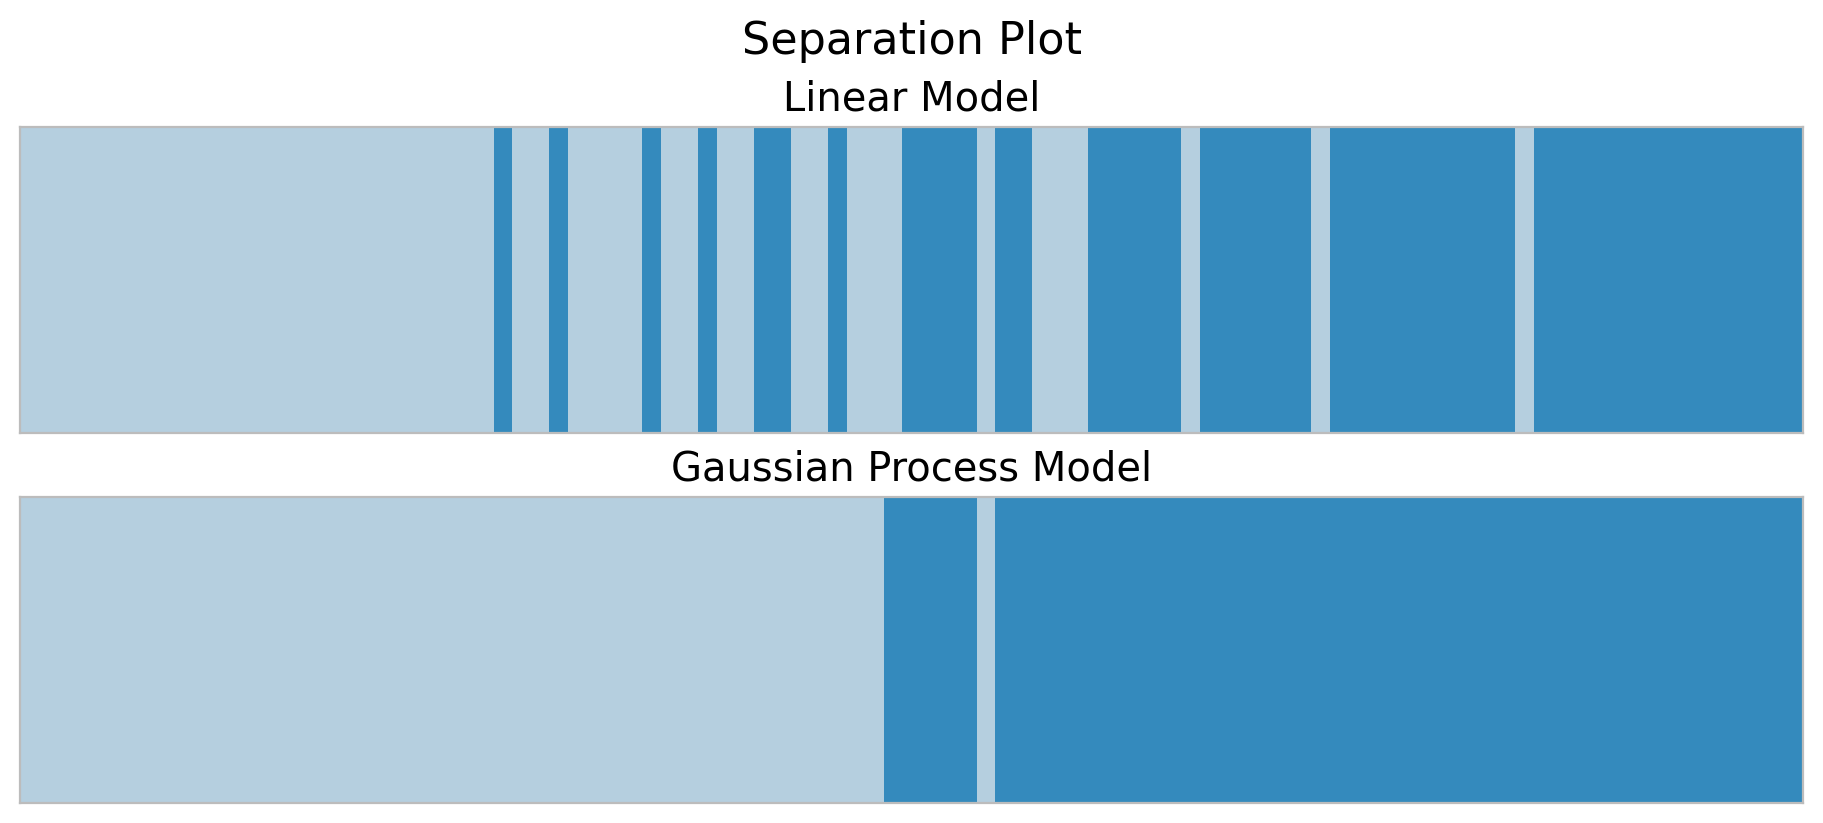

In [22]:
fig, ax = plt.subplots(
        nrows=2, ncols=1, figsize=(9, 4), layout="constrained"
)
az.plot_separation(idata=linear_posterior_predictive, y="likelihood", ax=ax[0])
ax[0].set(title="Linear Model")
az.plot_separation(idata=gp_posterior_predictive, y="likelihood", ax=ax[1])
ax[1].set(title="Gaussian Process Model")
fig.suptitle("Separation Plot", fontsize=16);

We indeed see that in the training set the gaussian process model separates the classes better.

Next, we compare the errors of the posterior mean:

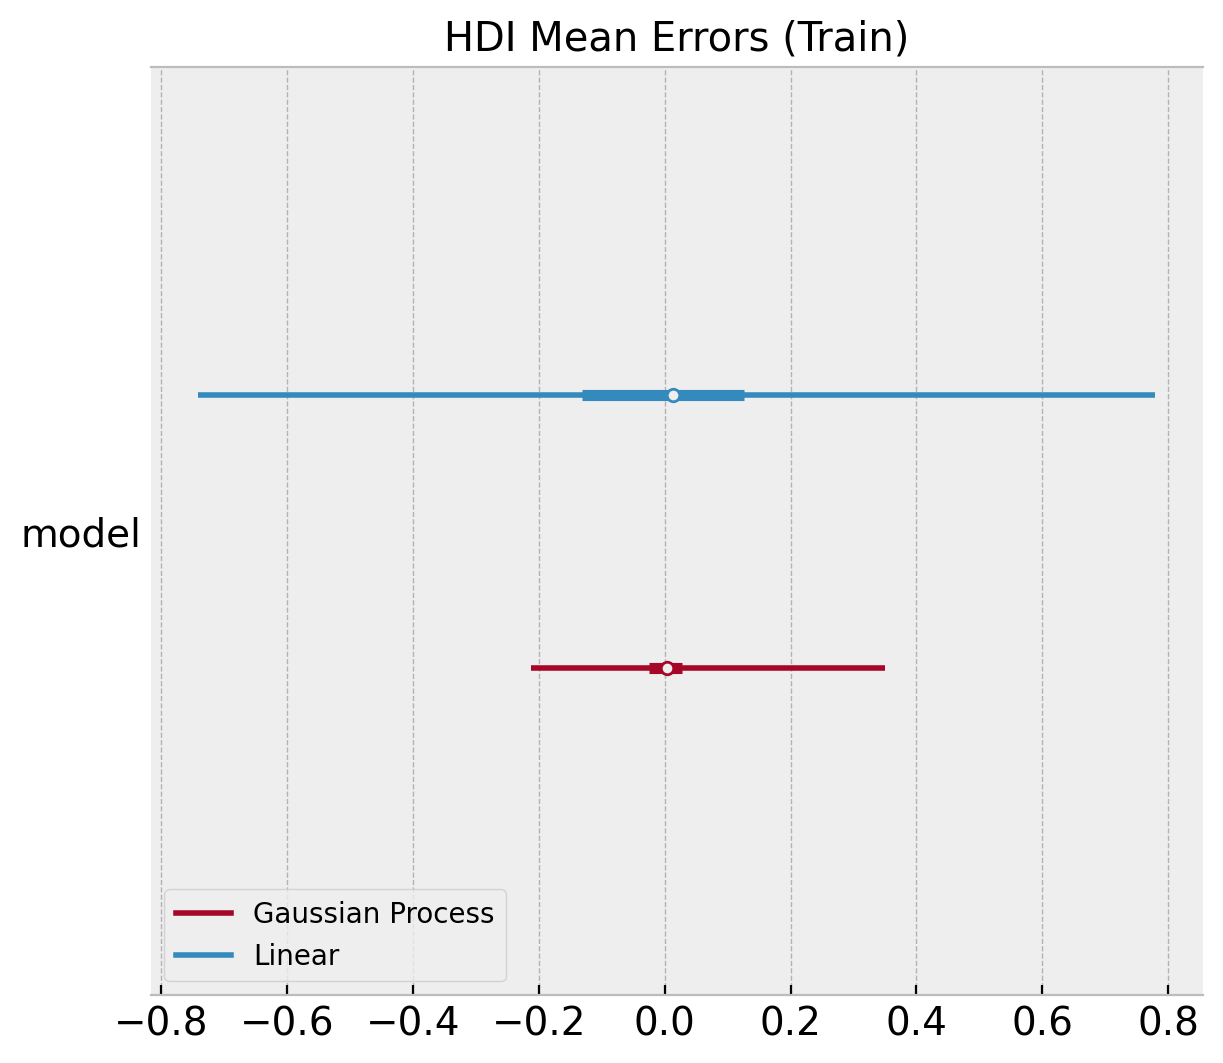

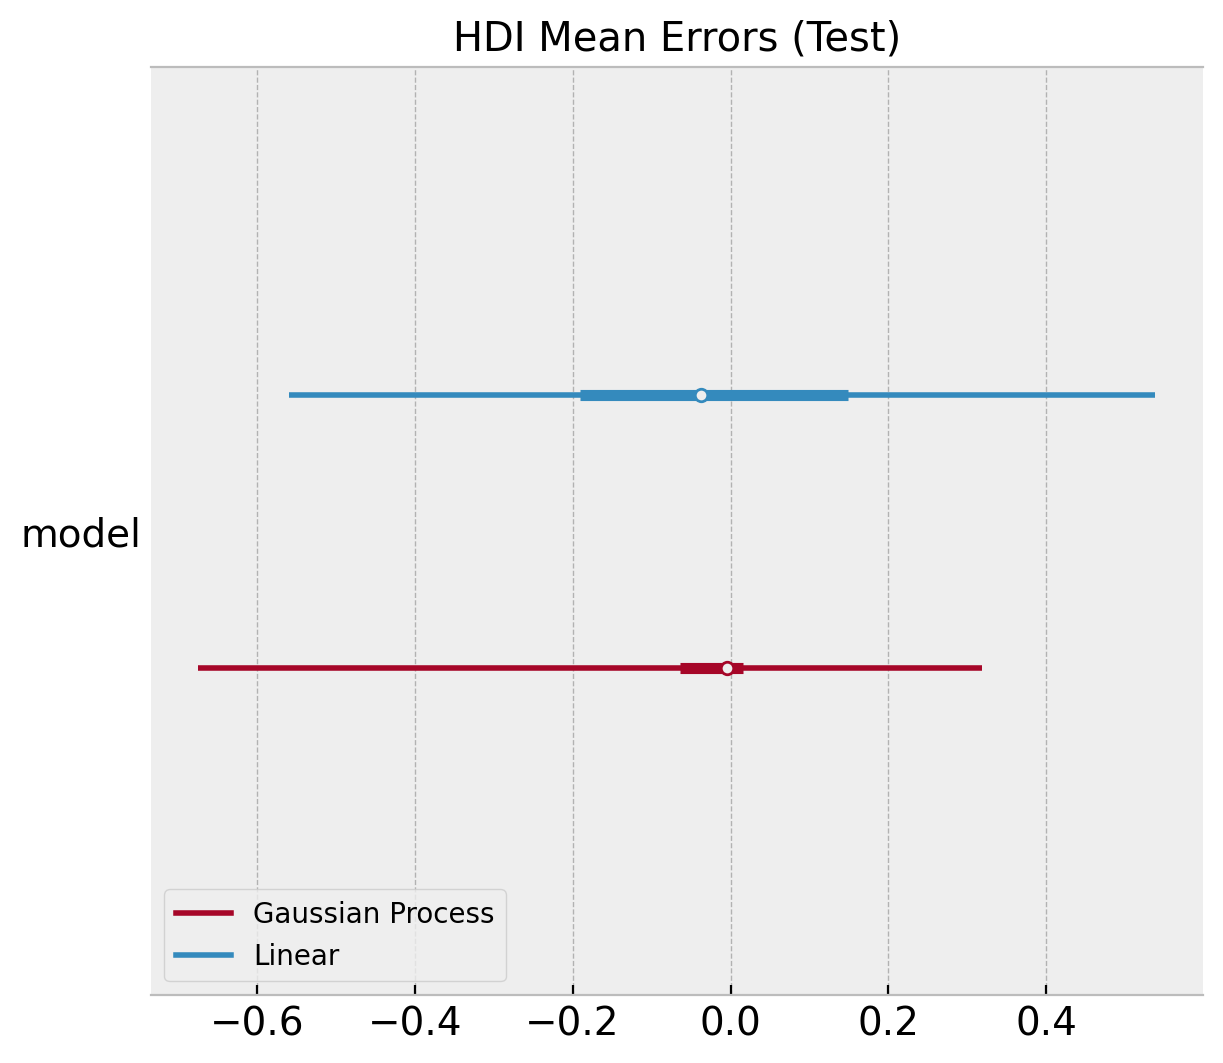

In [23]:
ax, *_ = az.plot_forest(
    [
        az.convert_to_dataset(obj={"model": linear_errors_mean_train.to_numpy()}),
        az.convert_to_dataset(obj={"model": gp_errors_mean_train.to_numpy()}),
    ],
    model_names=["Linear", "Gaussian Process"],
    backend_kwargs={"layout": "constrained"},
)
ax.set(title="HDI Mean Errors (Train)");

ax, *_ = az.plot_forest(
    [
        az.convert_to_dataset(obj={"model": linear_errors_mean_test.to_numpy()}),
        az.convert_to_dataset(obj={"model": gp_errors_mean_test}),
    ],
    model_names=["Linear", "Gaussian Process"],
    backend_kwargs={"layout": "constrained"},
)
ax.set(title="HDI Mean Errors (Test)");

We can plot similar diagnostics for the accuracy distributions.

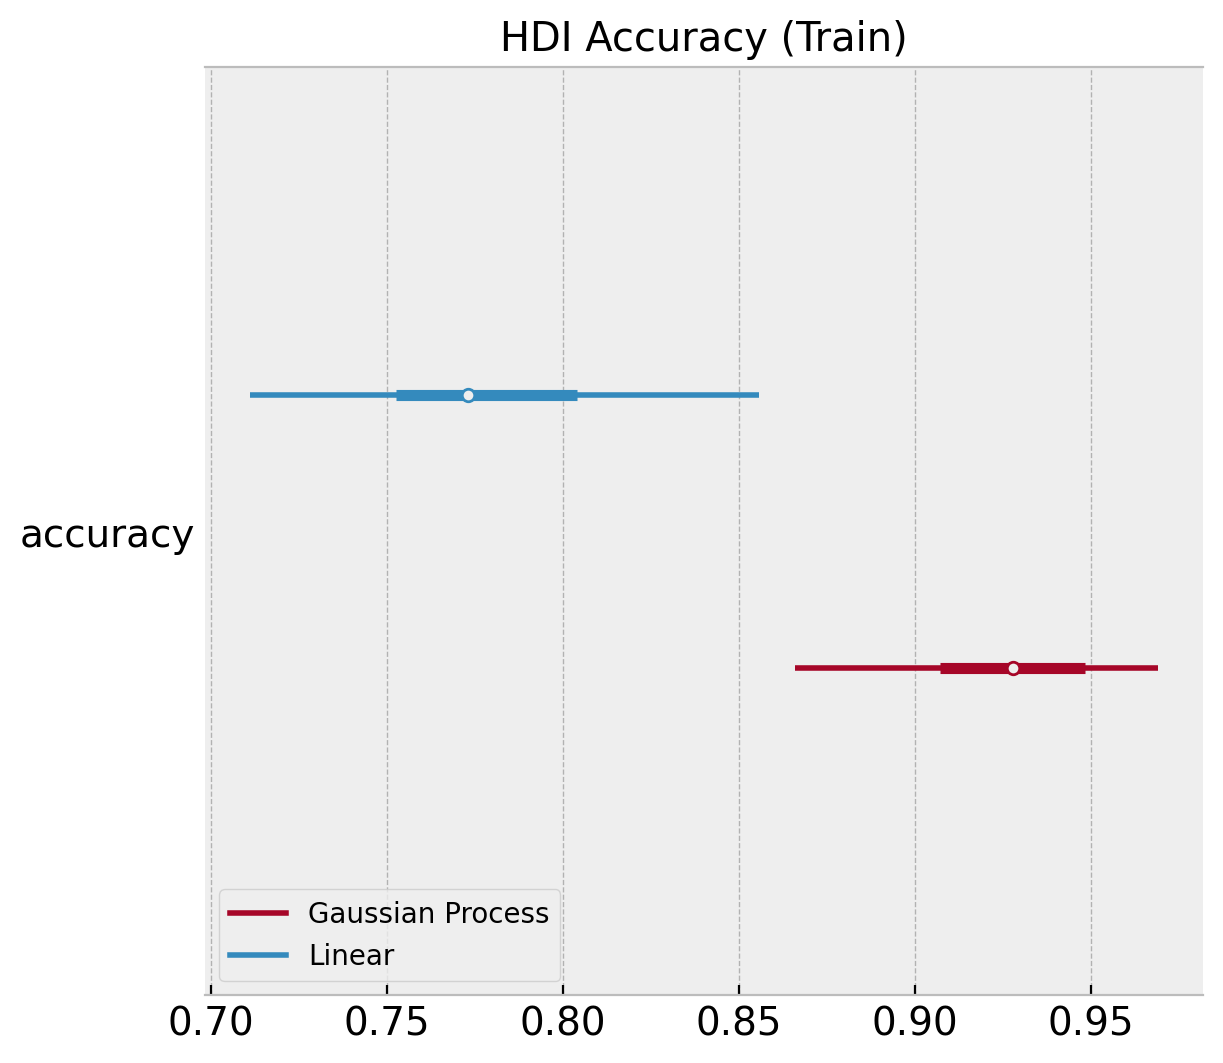

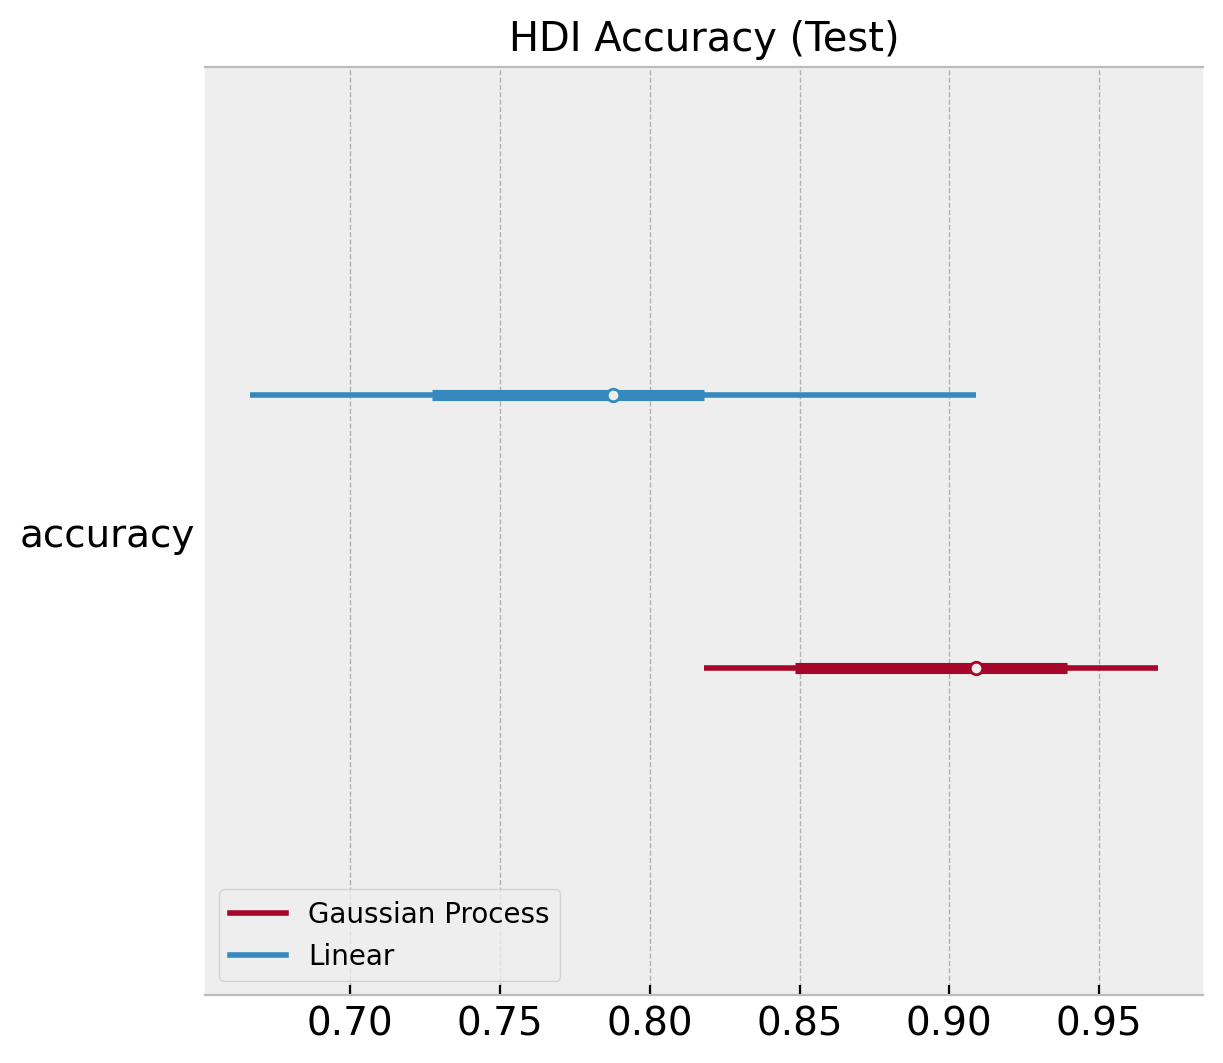

In [24]:
ax, *_ = az.plot_forest(
    [
        az.convert_to_dataset(obj={"accuracy": linear_acc_samples_train}),
        az.convert_to_dataset(obj={"accuracy": gp_acc_samples_train}),
    ],
    model_names=["Linear", "Gaussian Process"],
    backend_kwargs={"layout": "constrained"},
)
ax.set(title="HDI Accuracy (Train)");

ax, *_ = az.plot_forest(
    [
        az.convert_to_dataset(obj={"accuracy": linear_acc_samples_test}),
        az.convert_to_dataset(obj={"accuracy": gp_acc_samples_test}),
    ],
    model_names=["Linear", "Gaussian Process"],
    backend_kwargs={"layout": "constrained"},
)
ax.set(title="HDI Accuracy (Test)");

Finally, we can use the [`compare`](https://arviz-devs.github.io/arviz/api/generated/arviz.compare.html) function from [`arviz`](https://arviz-devs.github.io/arviz/):

In [28]:
comp_df = az.compare({"linear_model": linear_idata, "gaussian_process": gp_idata})
comp_df

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
gaussian_process,0,-11.786868,3.425920,0.000000,1.000000e+00,2.862920,0.000000,False,log
linear_model,1,-36.199844,2.237104,24.412976,4.309442e-12,5.432254,4.256246,False,log


Here we see more metrics showing how the gaussian process model is much better model that the logistic regression.

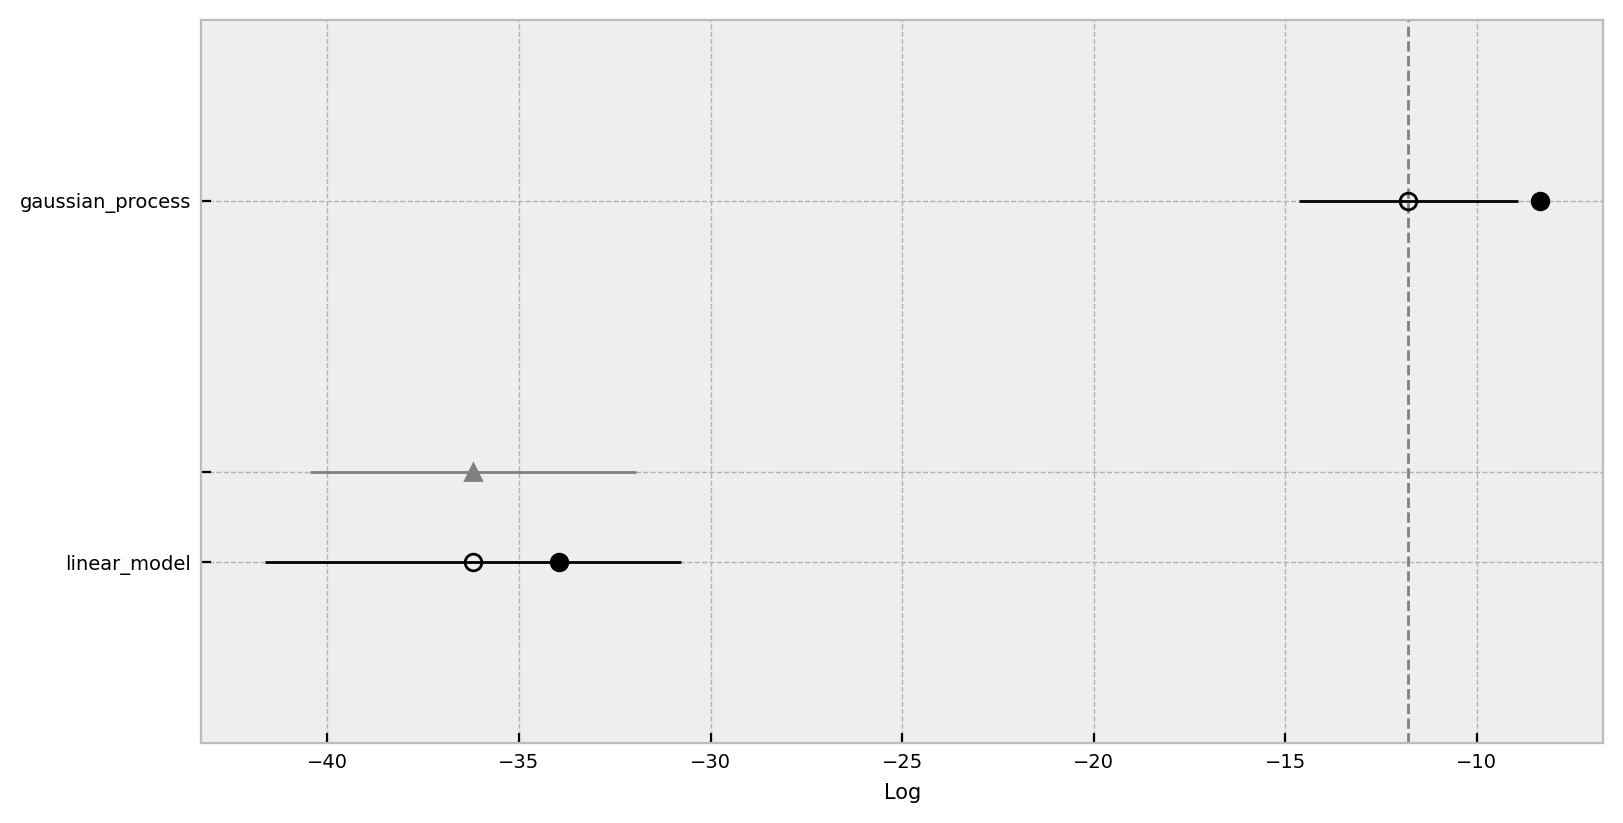

In [35]:
az.plot_compare(comp_df=comp_df, backend_kwargs={"figsize": (8, 4), "layout": "constrained"});

Regarding this compare plot:

>*This plot is in the style of the one used in the book [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/) by Richard McElreath.Chapter 6 in the first edition or 7 in the second.*